Case: https://github.com/ifood/ifood-data-business-analyst-test

**Summary**

    0.0 Imports
        0.1 Helper Functions
        0.2 Loading Data
    1.0 Describe Data
        1.1 Rename Columns
        1.2 Dealing with Missing Values
        1.3 Change Data Types
        1.4 Duplicates
        1.5 Descriptive Statistical
            1.5.1. Numerical Attributes
                1.5.1.2 Adjustments
            1.5.2. Categorical Attributes
    2.0 Hypothesis Creation
        2.1 Hypotheses
    3.0 Feature Engineering
        3.0.1. dependents_number
        3.0.2. num_purchases
        3.0.3. num_accepted_cmps
        3.0.4. amount_spent
        3.0.5. loyalty_time
        3.0.6. mean_amount_spent_per_month
        3.0.7. age
        3.0.8. spent_percentage
        3.0.9. purchases_percentage
    4.0 Filtering The Features
        4.1 Final modifications
    5.0 Exploratory Data Analysis
            5.1.1 Response Variable
            5.1.2 Numerical Variables
            5.1.3 Categorical Variables
        5.2 Bivariate Analysis
            5.2.1. Type of Product
            5.2.2. Type of Purchase
            5.2.3. Customers
            Second Cycle
        5.3 Multivariate Analysis
            5.3.1. Numerical Attributes
            5.3.2. Categorical Attributes

<font color='grey'>Grey color means notes from studies after finishing the core process of the project.</font>

# 0.0 Imports

In [185]:
import pandas as pd
import inflection
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from IPython.display import Image
from scipy import stats

## 0.1 Helper Functions

In [2]:
def describe_data(data):
    print(f"Shape: {data.shape}")
    print(f"Duplicates: {data.duplicated().any()}")
    
    is_na = data.isna().sum()
    is_na_percentage = data.isna().sum()/data.shape[0]*100
    nan_data_frame = pd.concat([data.dtypes, is_na, is_na_percentage], axis=1)
    nan_data_frame.columns = ['data_types', 'nan_count', 'nan_percentage']
    return nan_data_frame


# 5.1.3. Categorical Variables    
def get_categories(data):
    df = pd.DataFrame()
    for column in data.columns:
        col = pd.Series(data[column].unique(), name=column)
        df = pd.concat([df, col], axis=1).fillna('')
    return df


# 5.2 Bivariate Analysis
# 5.2.1. Type of Product
def calculate_median_sum(data_frame):
    medians = pd.DataFrame( data_frame.median(), columns=['median'] )
    sums = pd.DataFrame( data_frame.sum(), columns=['sum'] )
    per_month = (sums.drop('mnt_gold_prods')/24).round(2) # 2 years
    per_month.columns = ['per_month']
    return pd.concat([medians, sums, per_month], axis=1).sort_values("median",ascending=False)


# 5.3 Multivariate Analysis 
#  5.3.2. Categorical Attributes
def cramer_v( x, y ):
    confusion_matrix = pd.crosstab( x, y ).to_numpy() 
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape
    
    chi2 = stats.chi2_contingency( confusion_matrix )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def get_categorical_corr(categorical_data):
    categorical_correlation_matrix = {}

    for column in categorical_data.columns:
        correlation_values = []
        for col in categorical_data.columns:
            correlation_values.append(cramer_v(categorical_attributes[column], categorical_attributes[col]))

        categorical_correlation_matrix[column] = correlation_values
    
    categorical_corr = pd.DataFrame(categorical_correlation_matrix)
    categorical_corr = categorical_corr.set_index( categorical_corr.columns )
    return categorical_corr 

In [3]:
# Second Cycle - Some Changes I made when reviewing
grey = '#999999'
blue = '#3498db'
light_grey = '#737373'
title_grey = '#4d4d4d'
strong_grey ='#0e0e0e'

## 0.2 Loading Data

In [4]:
raw_data = pd.read_csv("data/ml_project1_data.csv").drop(columns="ID")
raw_data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,...,7,0,0,0,0,0,0,3,11,1
1,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,...,5,0,0,0,0,0,0,3,11,0
2,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,4,0,0,0,0,0,0,3,11,0
3,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,...,6,0,0,0,0,0,0,3,11,0
4,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,5,0,0,0,0,0,0,3,11,0


# 1.0 Describe Data

In [5]:
data = raw_data.copy()

## 1.1 Rename Columns

In [6]:
old_columns = data.columns

# transform snakecase with inflection
snakecase = lambda x: inflection.underscore(x)
new_columns = map(snakecase, old_columns)

data.columns = new_columns
data.columns

Index(['year_birth', 'education', 'marital_status', 'income', 'kidhome',
       'teenhome', 'dt_customer', 'recency', 'mnt_wines', 'mnt_fruits',
       'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products',
       'mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases',
       'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month',
       'accepted_cmp3', 'accepted_cmp4', 'accepted_cmp5', 'accepted_cmp1',
       'accepted_cmp2', 'complain', 'z_cost_contact', 'z_revenue', 'response'],
      dtype='object')

> **Data Dimension. Data Types. Check NaN.**


- **Fill in missing values**
    - income - customer's yearly household income
- **Convert to datetime**
    - dt_customer - date of customer's enrollment with the company
- **Remove Duplicates**

In [7]:
describe_data(data)

Shape: (2240, 28)
Duplicates: True


,data_types,nan_count,nan_percentage
year_birth,int64,0,0.000000
education,object,0,0.000000
marital_status,object,0,0.000000
income,float64,24,1.071429
kidhome,int64,0,0.000000
teenhome,int64,0,0.000000
dt_customer,object,0,0.000000
recency,int64,0,0.000000
mnt_wines,int64,0,0.000000
mnt_fruits,int64,0,0.000000


## 1.2 Dealing with Missing Values

We could have just dropped them, since there are so few missing values. However, there are also few data, then let's try to keep them. 

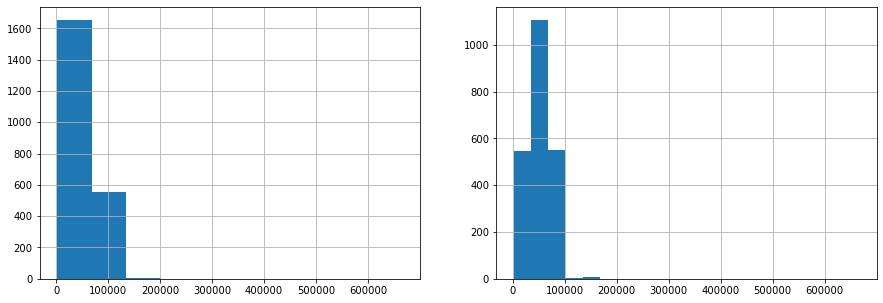

In [8]:
plt.figure(figsize=(15,5))
plt.subplot( 1, 2, 1 )
data['income'].hist()
plt.subplot( 1, 2, 2 )
data['income'].hist(bins=20)
plt.show()

In [9]:
print( f"skew   {data['income'].skew()}" )
print( f"mean   {data['income'].mean()}" )
print( f"median {data['income'].median()}" )

skew   6.763487372811116
mean   52247.25135379061
median 51381.5


In [10]:
data['income'].fillna(data['income'].mean(), inplace=True)

## 1.3 Change Data Types

In [11]:
data['dt_customer'] = pd.to_datetime( data['dt_customer'] )

## 1.4 Duplicates

In [12]:
# Duplicated rows
print("number of duplicates: ", data.duplicated().sum())
duplicated_rows_df = data[data.duplicated(keep=False)]
duplicated_rows_df.sort_values("year_birth").head()

number of duplicates:  182


,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mnt_wines,mnt_fruits,...,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,z_cost_contact,z_revenue,response
894,1943,PhD,Divorced,48948.0,0,0,2013-02-01,53,437,8,...,6,1,0,0,0,0,0,3,11,1
39,1943,PhD,Divorced,48948.0,0,0,2013-02-01,53,437,8,...,6,1,0,0,0,0,0,3,11,1
15,1946,PhD,Single,82800.0,0,0,2012-11-24,23,1006,22,...,3,0,0,1,1,0,0,3,11,1
1771,1946,PhD,Married,51012.0,0,0,2013-04-18,86,102,9,...,6,0,0,0,0,0,0,3,11,0
1747,1946,Master,Married,66835.0,0,0,2013-09-28,21,620,26,...,2,0,0,0,0,0,0,3,11,0


In [13]:
data.drop_duplicates(inplace=True)

## 1.5 Descriptive Statistical

In [14]:
numerical_attributes = data.select_dtypes( include=['int64', 'float64'] )
categorical_attributes = data.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.5.1. Numerical Attributes

    Minimum yearly household income of "1730.00"? Miss imputation? We have to adjust that.
    
    Wine seems to bring more revenue than others. Is it real or just a coincidence due to the 
    randomness on choosing those 2240 customers for test?
    
<font color='red'>**How? So few Values:**</font>    
    
    The rates of "accepted campaign" (accepted_cmp) are quite similar, but why the second one was not 
    welcomed? And why the last one (response) had the double of acceptance? It's a point that draws 
    attention for further analysis.
        
    "complain" rate (actually, if the customer complained in the last 2 years) seems pretty low (1%).
    With 1 million clients, this means about 10 thousand complainings in 2 years, but to be sure if 
    thats good or not... it depends on the company metric and goal.
    
    (Drop) "z_cost_contact" shows us a uniform value (11) throughout the columns and its standard 
    deviation is 0, which means the data has no dispersion. If there's no variation it doesn't tell us
    much. Let's just delete this column.
    
    (Drop) The same for "z_revenue".
    
    The success rate of the last campaign (response) was 15% (as specified in the pdf file).

In [15]:
skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew()), columns=['skew']).T
kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis()), columns=['kurtosis']).T
stats = pd.concat([data.describe(), skew, kurtosis]).round(2).T

def style_specific_cell(x):
    df = pd.DataFrame('', index=x.index, columns=x.columns)
    
    df.iloc[1, 2] = 'background-color: lightyellow'
    df.iloc[5, 0] = df.iloc[5, 4] = 'background-color: lightblue'
    df.iloc[6, 0] = df.iloc[7, 0] = df.iloc[8, 0] = df.iloc[9, 0] = df.iloc[10, 0] = 'background-color: lightgrey'
    df.iloc[-5, 0] = 'background-color: lightpink'
    df.iloc[-4, 0] = 'background-color: lightyellow'
    df.iloc[-1, 0] = 'background-color: lightgreen'
    
    return df

stats.drop(columns='count').style.apply(style_specific_cell, axis=None).format("{:.2f}")

,mean,std,min,25%,50%,75%,max,skew,kurtosis
year_birth,1968.79,11.97,1893.00,1959.00,1970.00,1977.00,1996.00,-0.38,0.85
income,52356.50,25377.61,1730.00,35701.75,52054.00,68242.50,666666.00,7.10,166.39
kidhome,0.45,0.54,0.00,0.00,0.00,1.00,2.00,0.62,-0.81
teenhome,0.51,0.55,0.00,0.00,0.00,1.00,2.00,0.41,-0.96
recency,48.95,29.00,0.00,24.00,49.00,74.00,99.00,0.00,-1.21
mnt_wines,303.92,336.53,0.00,23.00,174.00,504.00,1493.00,1.17,0.58
mnt_fruits,26.23,39.75,0.00,1.00,8.00,33.00,199.00,2.11,4.06
mnt_meat_products,167.70,228.30,0.00,16.00,67.00,229.50,1725.00,2.10,5.61
mnt_fish_products,37.33,54.66,0.00,3.00,12.00,50.00,259.00,1.93,3.13
mnt_sweet_products,27.18,41.71,0.00,1.00,8.00,33.75,263.00,2.15,4.42


<font color='grey'>Most of the features presents a distribution that is **highly skewed with heavy tails. This means that there is many data that is far from the mean. This could be a sign of outliers in the data for these features.**</font>

<br>

<font color='grey'>
    Conversion rate: num_web_purchases / num_web_visits_month. <br>
    4.1 / 5.32 = 0.77
</font>

In [16]:
data.z_revenue.unique()

array([11], dtype=int64)

In [17]:
data.z_cost_contact.unique()

array([3], dtype=int64)

#### 1.5.1.2 Adjustments

**Income: customer's yearly household income.**

A minimum annual income of R$1730.00 for a family is unrealistic. Let's guide this adjustment using the minimum salary in 2012, because we know that customer's minimum salary is at least from that year above.

As you can see, the last year that the company had a customer enrolled before the actions of the marketing department was in the middle of 2014, then the campaigns might have happened in July, August, September, October, November, December (perhaps, that's why the last campaign had the double of acceptance).

In [18]:
print( data['dt_customer'].min() )
print( data['dt_customer'].max() )

2012-07-30 00:00:00
2014-06-29 00:00:00


In [19]:
brazilian_min_salary_2012 = 622; TWELVE_MONTHS = 12
brazilian_min_annual_salary = brazilian_min_salary_2012 * TWELVE_MONTHS

In [20]:
data['income'] = data['income'].apply(lambda x: brazilian_min_annual_salary if x < brazilian_min_annual_salary else x)

**Delete uninformative columns: "z_cost_contact" and "z_revenue"**

In [21]:
data.drop(columns=["z_cost_contact", "z_revenue"], inplace=True)

### 1.5.2. Categorical Attributes

Marital status "Alone", "Absurd" and "YOLO" (you only live once) show us weird boxplots sometimes, after take look I found out there are an imbalance in the data. Let's then turn them into "Single" later. I'm not sure about transforming "Absurd" into "Single", because I don't know what it means and would need to get information about it with someone from the company, but since there are so few of them, I'll take the risk.

In [22]:
categorical_attributes.apply( lambda x: x.unique().shape[0] )

education         5
marital_status    8
dtype: int64

<font color='grey'>numerical_attributes.select_dtypes(include=['int64','float64'], exclude=['bool']).columns</font>

In [23]:
numerical_columns = []
# removing binary features (search for function that does this)
for column in numerical_attributes.columns:
    if numerical_attributes[column].nunique() > 2:
        numerical_columns.append(column)
len(numerical_columns)

16

In [24]:
categorical_attributes.shape[1]

2

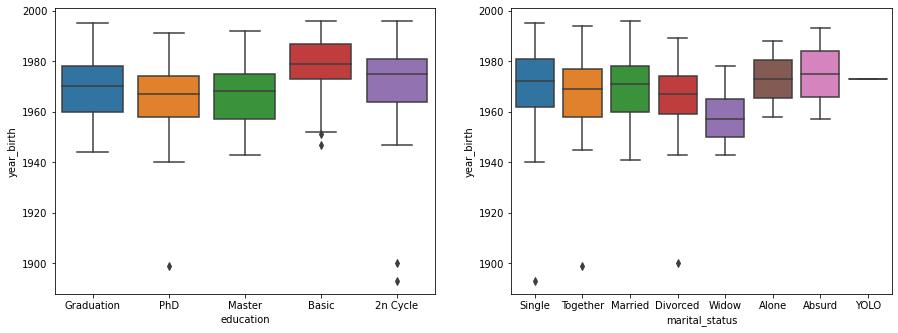

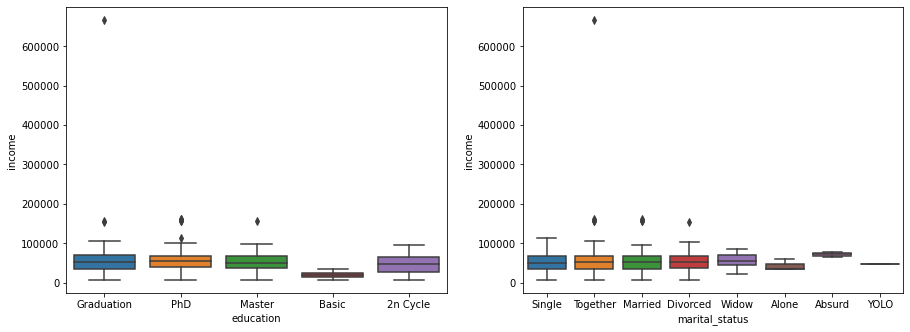

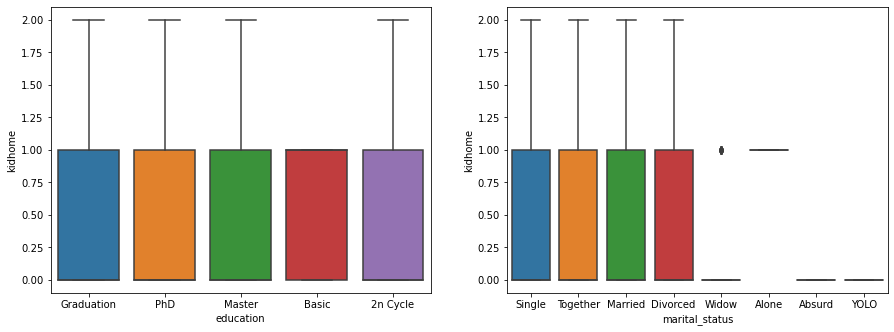

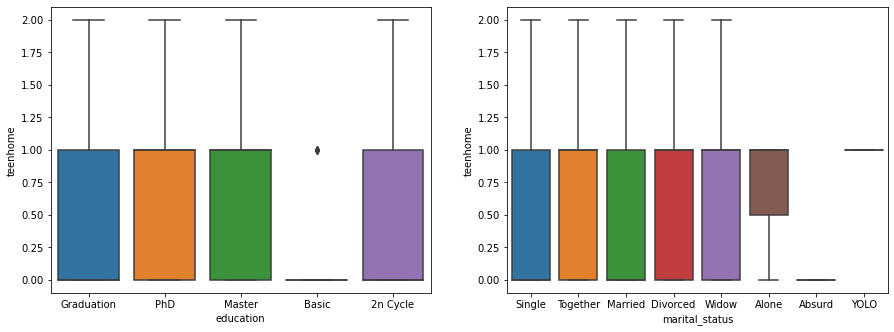

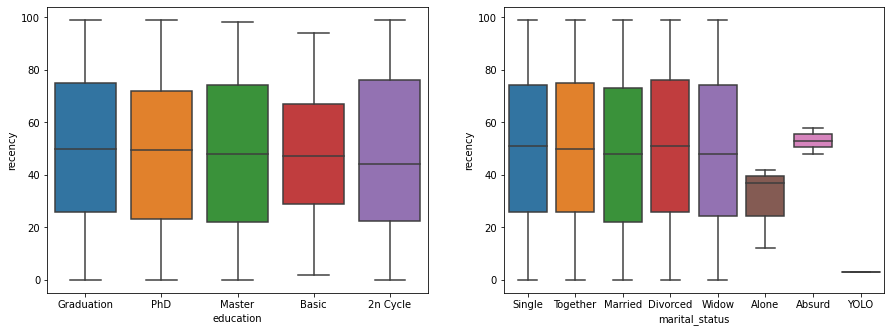

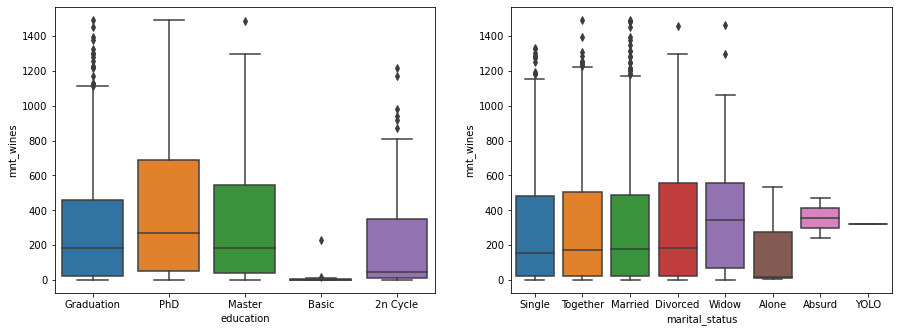

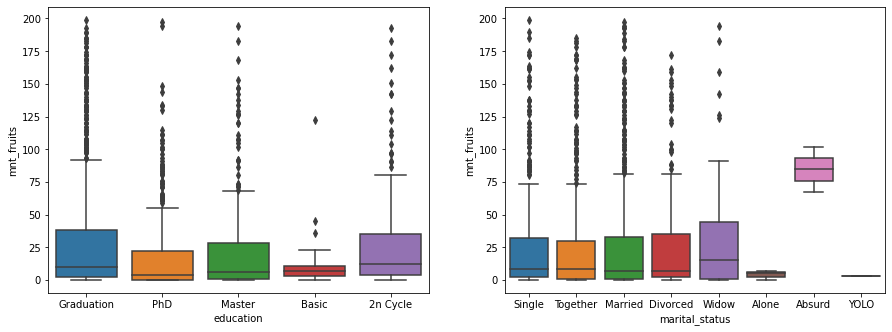

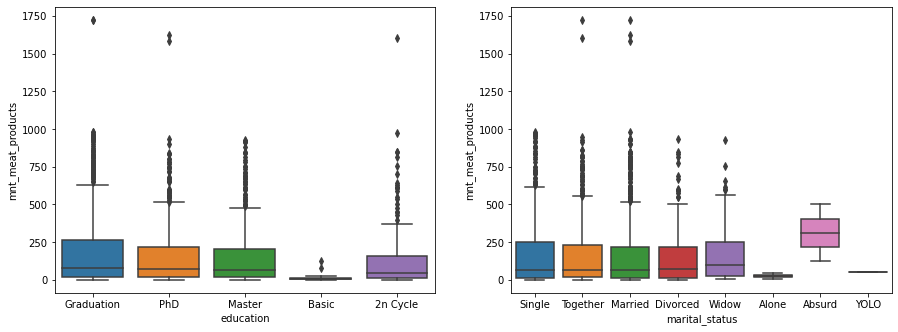

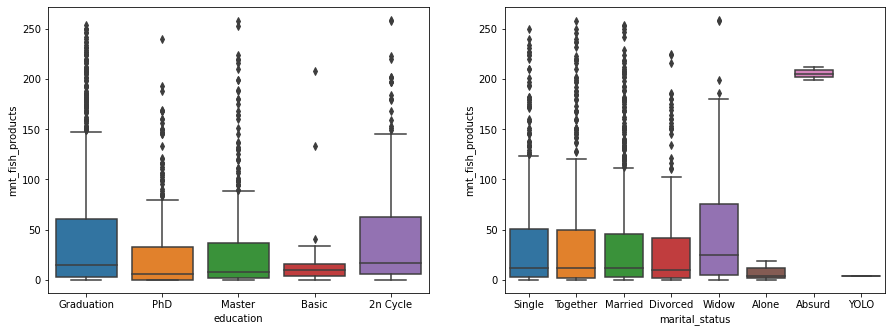

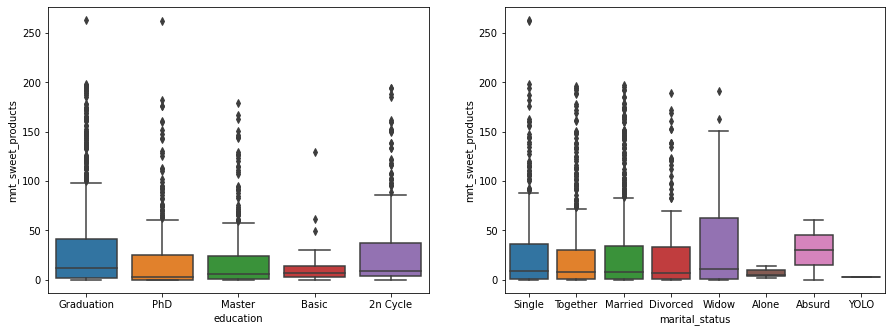

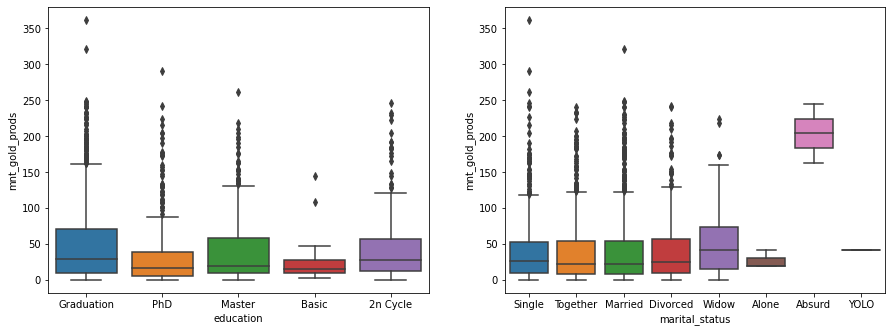

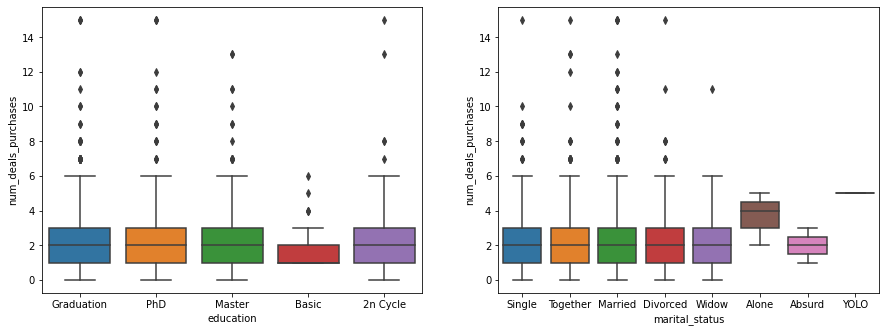

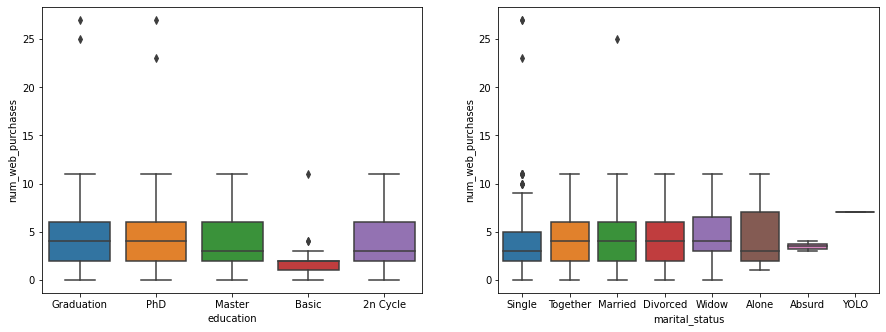

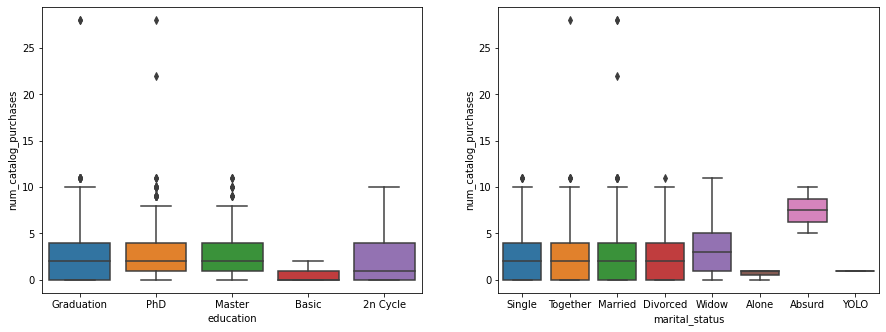

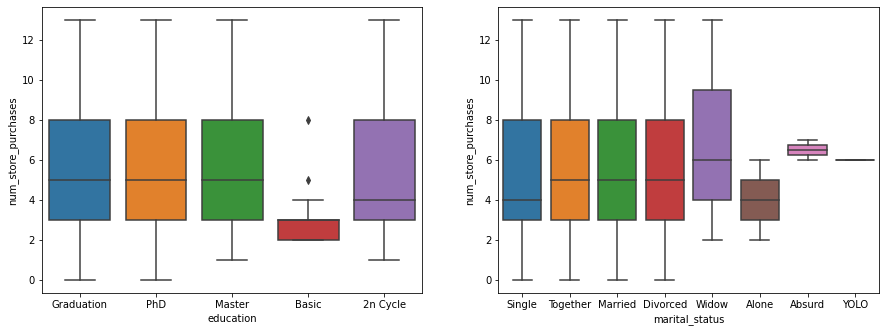

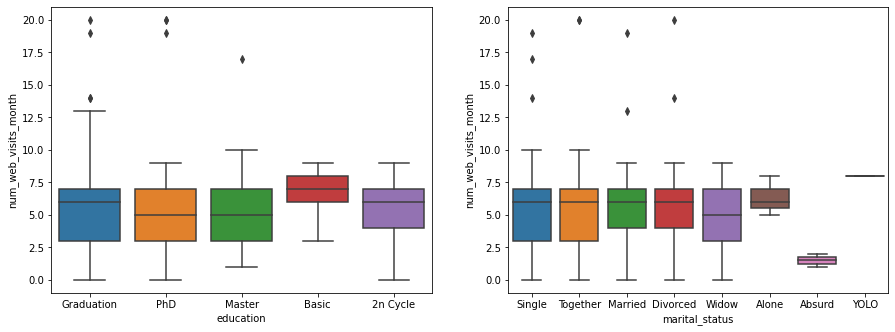

In [25]:
rows = len(numerical_columns); columns = categorical_attributes.shape[1]; plot = 0

for nth_attribute in numerical_columns:
    plt.figure(figsize=(15, 100))
    plot += 1    
    plt.subplot( rows, columns, plot )
    sns.boxplot( x='education', y = nth_attribute, data=data);
    
    plot += 1
    plt.subplot( rows, columns, plot )
    sns.boxplot( x='marital_status', y = nth_attribute, data=data);
    
    print("\n\n"); plt.show()

<font color='grey'>Depending on our objective, we could filter these outliers. In addition, if we were to apply a clustering algorithm like K-Means, the clustering would be negatively affected, as K-Means is sensitive to outliers.</font>

In [26]:
pd.DataFrame( categorical_attributes['marital_status'].value_counts() )

,marital_status
Married,795
Together,521
Single,448
Divorced,216
Widow,71
Alone,3
Absurd,2
YOLO,2


## 2.0 Hypothesis Creation

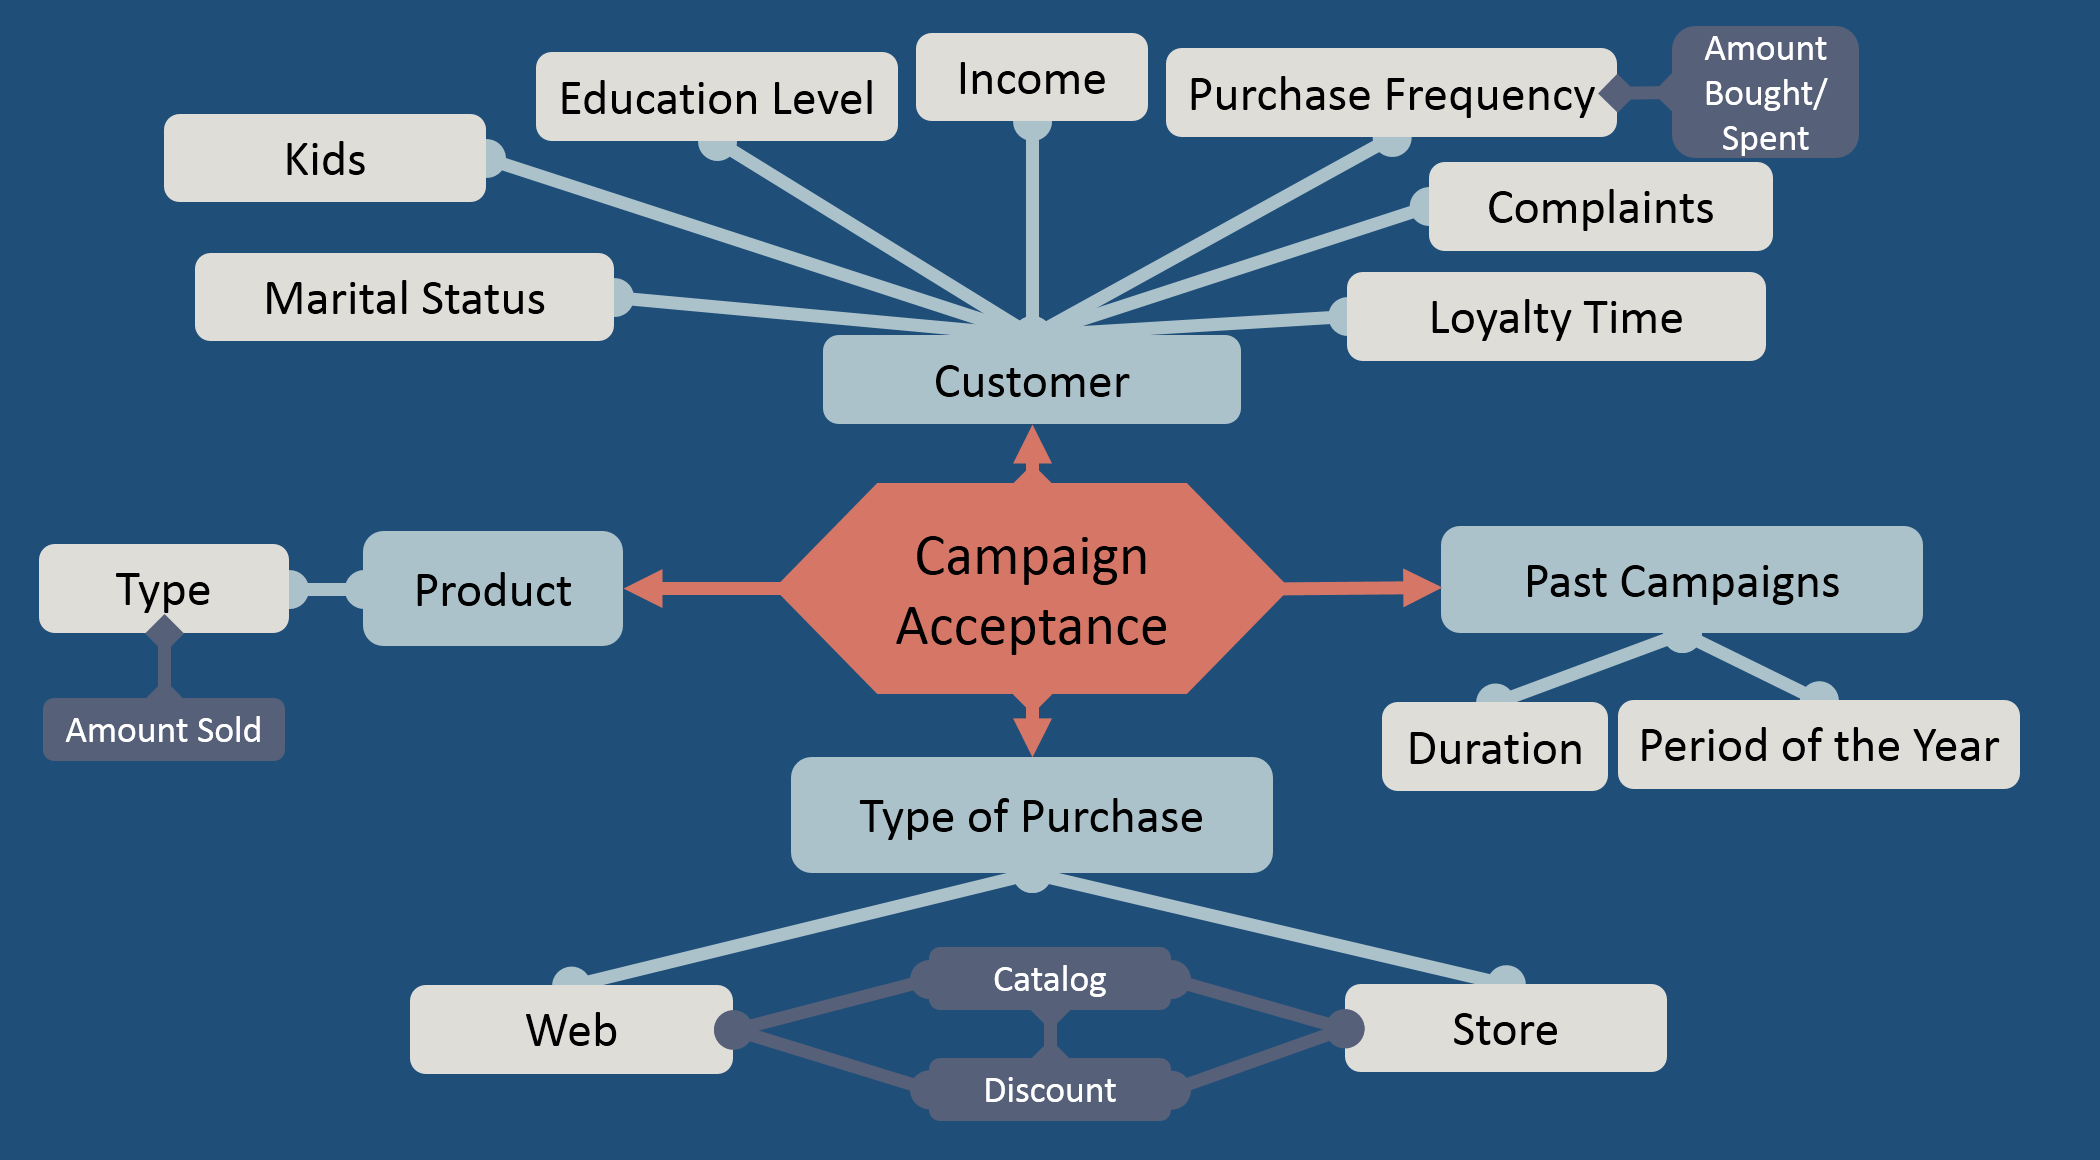

In [27]:
Image('./images/hypotheses_mind_map.png', width=900)

### 2.1 Hypotheses

**1. Type of Product.**

    What type of product brings more revenue?

    What type of product brings more revenue in web purchases?

    What type of product brings more revenue in store purchases?

    What type of product brings more revenue in catalog purchases?

    What type of product brings more revenue in discount purchases?
    
**2. Type of Purchase.**

**Web purchases bring more revenue than purchases made in stores.**

**More discounts are made in Web purchases.** 

**More catalog purchases are made in Stores.**

    Which type of purchase has higher "rates of acceptance" from last campaign?
    
**3. Customers.**

**Older Customers tend to accept the campaign.**

**Older Customers bring more revenue.**

**Customers with no complaints tend to accept the campaign.**

**Customers with no complaints bring more revenue.**

**Customers who buy more frequently tend to accept the campaign.**

**Customers who buy more frequently bring more revenue.**

**Customers with higher income tend to accept the campaign.**

**Customers with higher income bring more revenue.**

**Customers with greater educational level tend to accept the campaign.**

**Customers with greater educational level bring more revenue.**

**Customers with two kids tend to accept the campaign.**

**Customers with two kids bring more revenue.**

**Single Customers tend to accept the campaign.**

**Single Customers bring more revenue.**

    Which marital status has higher rates of acceptance from the last campaign?

    Which marital status has accepted more campaigns?

    Which marital status brings more revenue?

## 3.0 Feature Engineering

In [28]:
data_frame = data.copy()

**3.0.1. dependents_number**

In [29]:
data_frame["dependents_number"] = data_frame['kidhome'] + data_frame['teenhome']

**3.0.2. num_purchases**

    "num_deals_purchases" - purchases made with discount may have been made from web, stores or catalogues.
    That's why We're not including it.

In [30]:
data_frame["num_purchases"] = data_frame["num_web_purchases"] + data_frame["num_catalog_purchases"] + \
                              data_frame["num_store_purchases"]

**3.0.3. num_accepted_cmps**

    We can not include the last campaign (response) due to data leakage.

In [31]:
data_frame["num_accepted_cmps"] = data_frame["accepted_cmp1"] + data_frame["accepted_cmp2"] + \
                                  data_frame["accepted_cmp3"] + data_frame["accepted_cmp4"] + \
                                  data_frame["accepted_cmp5"]

**3.0.4. amount_spent**

_"They sell products from 5 major categories: wines, rare meat products, exotic fruits, specially<br>
prepared fish and sweet products. These can further be divided into gold and regular products."_
        
    Then, the money spent on gold is already included on each "mnt_"

In [32]:
data_frame["amount_spent"] = data_frame['mnt_wines'] + data_frame['mnt_fruits'] + data_frame['mnt_meat_products'] + \
                             data_frame['mnt_fish_products'] + data_frame['mnt_sweet_products'] 
# + data_frame['mnt_gold_prods']

**3.0.5. loyalty_time**

    I am assuming the marketing campaign tests started right after the last customer in the dataset has joined the company
    (in the next month).

In [33]:
#data_frame['dt_customer'].max() # '2014-06-29 00:00:00'

In [34]:
data_frame['loyalty_time_days'] = (pd.to_datetime('2014-07-01 00:00:00') - data_frame['dt_customer']).dt.days

In [35]:
data_frame['loyalty_time_years'] = data_frame['loyalty_time_days']/365

In [36]:
data_frame['loyalty_time_months'] = data_frame['loyalty_time_days']/30

**3.0.6. mean_amount_spent_per_month**

    We have to avoid these crazy results where the amount per month is greater than the amount of 2 years 

In [37]:
c = ['dt_customer', 'amount_spent', 'loyalty_time_months']
invalid_amount = data_frame.loc[ (data_frame['amount_spent'] > 900) & (data_frame['loyalty_time_months'] < 1), c ].head()
invalid_amount['mean_amount_spent_per_month'] = invalid_amount['amount_spent'] / invalid_amount['loyalty_time_months']
invalid_amount

,dt_customer,amount_spent,loyalty_time_months,mean_amount_spent_per_month
53,2014-06-07,1376,0.800000,1720.0
266,2014-06-26,1254,0.166667,7524.0
347,2014-06-16,972,0.500000,1944.0
631,2014-06-13,909,0.600000,1515.0
1032,2014-06-25,1051,0.200000,5255.0


In [38]:
# test = data_frame.apply(lambda df: df['amount_spent'] / df['loyalty_time_months'] if df['loyalty_time_months'] > 1
#                      else df['amount_spent'],axis=1)
# test.hist()
# test.mean()

In [39]:
data_frame['mean_amount_spent_per_month'] = data_frame.apply(lambda df: df['amount_spent'] / df['loyalty_time_months']
                                                             if df['loyalty_time_months'] > 1 else df['amount_spent'], axis=1)

**3.0.7. age**

In [40]:
current_year = data_frame.dt_customer.dt.year.max() # 2014

In [41]:
data_frame['age'] = current_year - data_frame['year_birth']

**3.0.8. spent_percentage**

In [42]:
data_frame["spent_percentage_wines"]  = data_frame['mnt_wines']/data_frame["amount_spent"]
data_frame["spent_percentage_fruits"] = data_frame['mnt_fruits']/data_frame["amount_spent"]
data_frame["spent_percentage_meat"]   = data_frame['mnt_meat_products']/data_frame["amount_spent"]
data_frame["spent_percentage_fish"]   = data_frame['mnt_fish_products']/data_frame["amount_spent"]
data_frame["spent_percentage_sweet"]  = data_frame['mnt_sweet_products']/data_frame["amount_spent"]
data_frame["spent_percentage_gold"]   = data_frame['mnt_gold_prods']/data_frame["amount_spent"]

**3.0.9. purchases_percentage**

In [43]:
data_frame["percentage_web_purchases"]     = data_frame["num_web_purchases"]/data_frame["num_purchases"]
data_frame["percentage_catalog_purchases"] = data_frame["num_catalog_purchases"]/data_frame["num_purchases"]
data_frame["percentage_store_purchases"]   = data_frame["num_store_purchases"]/data_frame["num_purchases"]

## 4.0 Filtering The Features

In [44]:
df = data_frame.copy()

### 4.1 Final modifications

In [45]:
df['marital_status'].replace("YOLO", "Single", inplace=True)
df['marital_status'].replace("Alone", "Single", inplace=True)
df['marital_status'].replace("Absurd", "Single", inplace=True)

## 5.0 Exploratory Data Analysis

In [46]:
ifood = df.copy()

temporary_desc = describe_data(ifood)
temporary_desc

Shape: (2058, 44)
Duplicates: True


,data_types,nan_count,nan_percentage
year_birth,int64,0,0.000000
education,object,0,0.000000
marital_status,object,0,0.000000
income,float64,0,0.000000
kidhome,int64,0,0.000000
teenhome,int64,0,0.000000
dt_customer,datetime64[ns],0,0.000000
recency,int64,0,0.000000
mnt_wines,int64,0,0.000000
mnt_fruits,int64,0,0.000000


In [47]:
temporary_desc['data_types'].unique()

array([dtype('int64'), dtype('O'), dtype('float64'), dtype('<M8[ns]')],
      dtype=object)

In [48]:
ifood.drop_duplicates(inplace=True)

In [49]:
ifood.fillna(0, inplace=True) # due to 0/0

In [50]:
numerical_attributes = ifood.select_dtypes( include=['int64', 'float64'] )
categorical_attributes = ifood.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 5.1.1. Response Variable

> **Imbalanced data. We'll have to deal with this later (under/oversampling).**

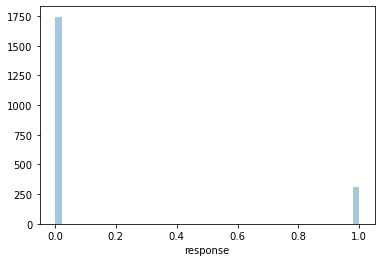

In [51]:
sns.distplot(ifood['response'], kde=False);

### 5.1.2. Numerical Variables

> year_birth (age).

    Most customers are between 30 and 60 years old.
    
> income
    
    Most customers have an yearly household income between 25,000 and 75,000
    
> num_web_visits_month (Amount Spent).

    Even though the amount spent tend to be low, the number of web visits tends to be high.
    Probably because people look for food quite frequently in the website and buy it in little quantities.
    
> dependents_number

    Usually families have 1 dependent only (a kid or a teen), as we also see in kidhome and teenhome.
    
> num_accepted_cmps

    70% of people who has accepted some campaign, has accepted only 1 of them. Then, after a campaign it's hard
    for the person to accept another.

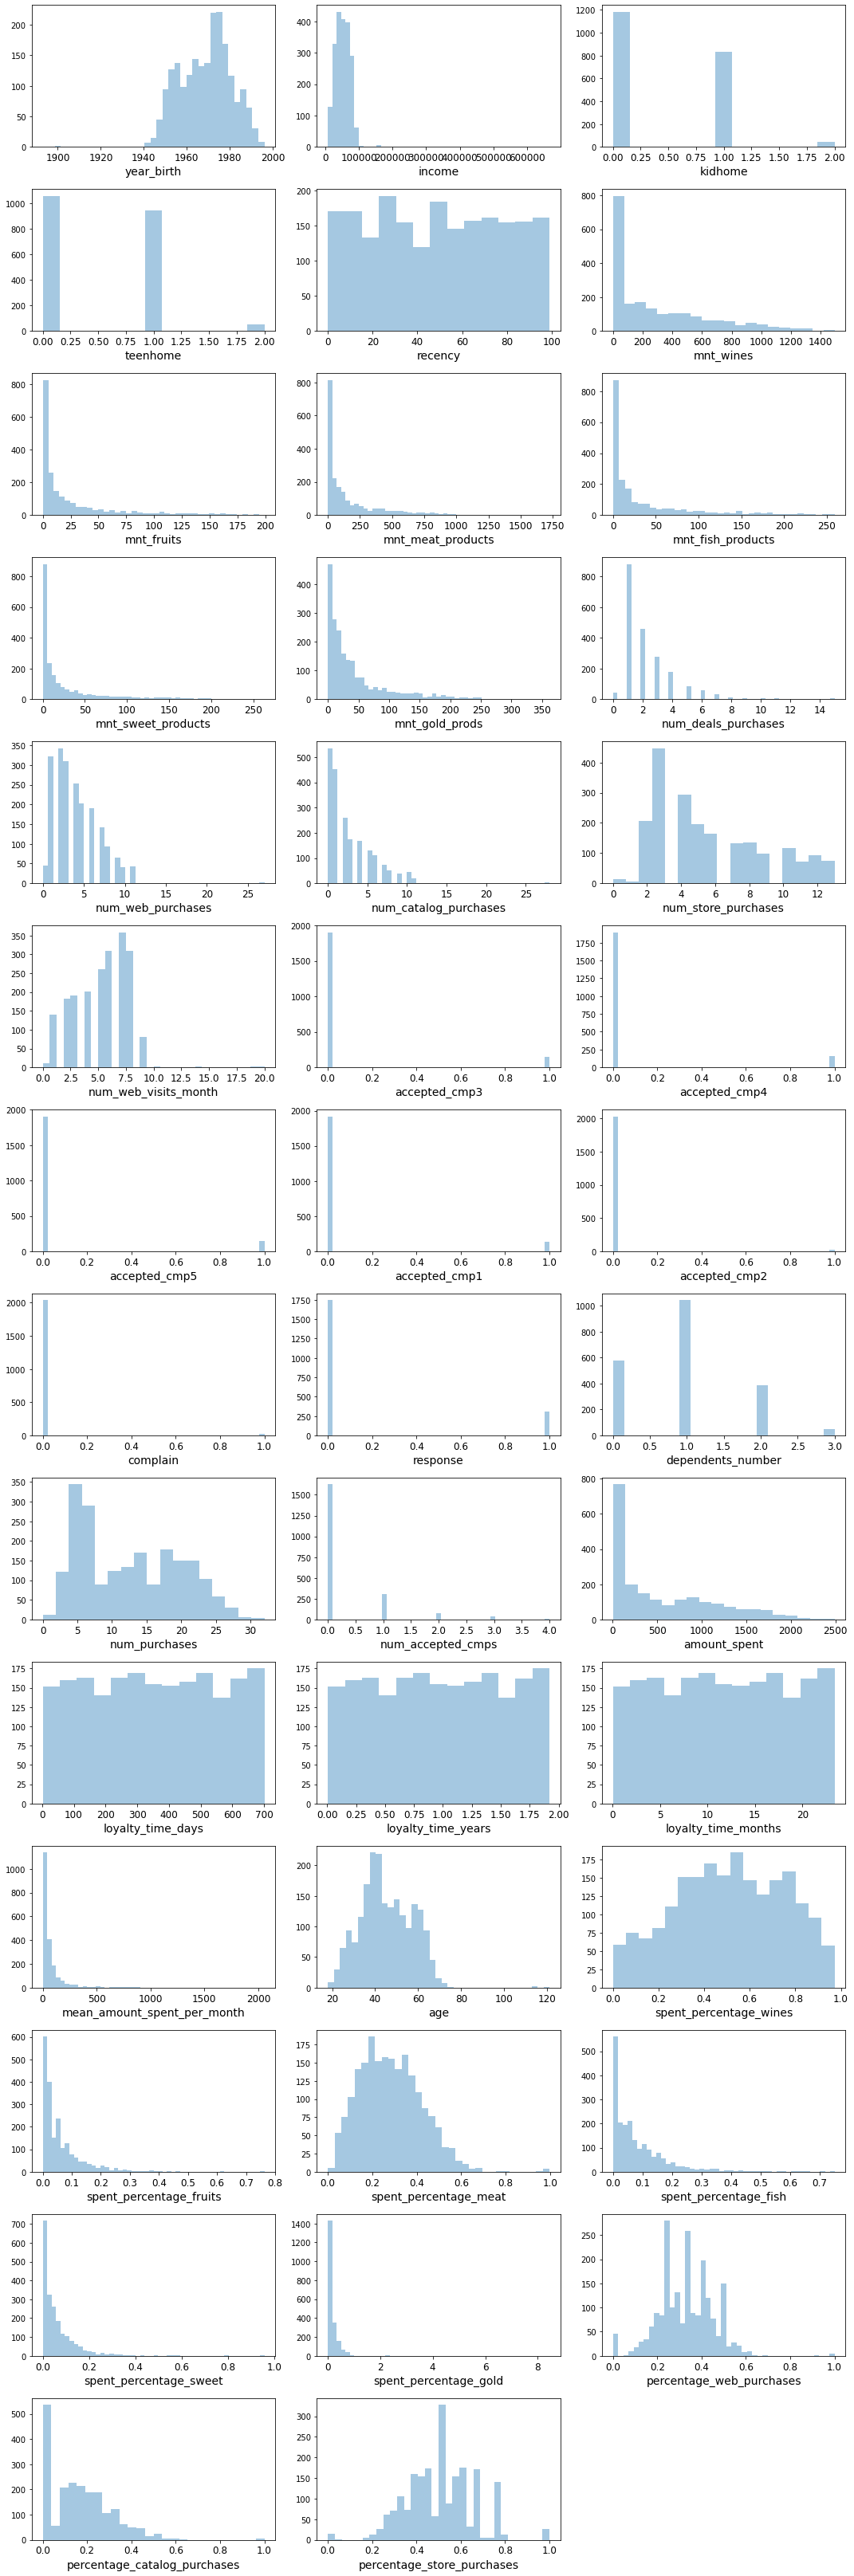

In [52]:
plt.figure(figsize=(15,45))
for column, subplot in zip(numerical_attributes, range(len(numerical_attributes))):
    plt.subplot(14, 3, subplot+1)
    sns.distplot( numerical_attributes[column], kde=False )
    plt.xlabel(column,fontsize=14); plt.xticks(fontsize=12)
plt.tight_layout()

Mean  52381.66100802088


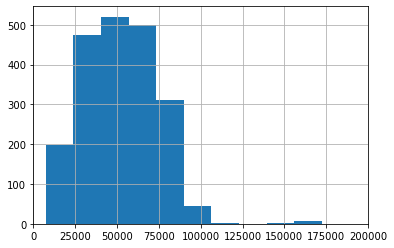

In [53]:
print("Mean ", ifood['income'].mean())
ifood['income'].hist(bins=40)
plt.xlim(0, 200000);

In [54]:
# Or kid or teen
print( len(ifood[ ifood['kidhome'] > 1]) )
print( len(ifood[ ifood['teenhome'] > 1]) )
print( len(ifood[ ifood['kidhome'] == 1]) )
print( len(ifood[ ifood['teenhome'] == 1]) )

43
50
830
947


79% of customers didn't accepted any previous campaign.

In [55]:
ifood['num_accepted_cmps'].value_counts(normalize=True)

0    0.790370
1    0.147860
2    0.037451
3    0.019455
4    0.004864
Name: num_accepted_cmps, dtype: float64

From those who accepted some campaign, 70% accepted only 1 of them.

In [56]:
ifood.loc[ifood['num_accepted_cmps'] > 0, 'num_accepted_cmps'].value_counts(normalize=True)

1    0.705336
2    0.178654
3    0.092807
4    0.023202
Name: num_accepted_cmps, dtype: float64

**The more the campaigns accepted, lower the chance they accept our target campaign.**

In [57]:
response_per_cmps = ifood.groupby('num_accepted_cmps')['response'].sum()
response_per_cmps

num_accepted_cmps
0    137
1     95
2     39
3     32
4      9
Name: response, dtype: int64

In [58]:
# From customers who haven't accepted any of the 5 campaigns, 8% accepted only the target campaign.
accepted_no_cmps = ifood[ ifood['num_accepted_cmps'] == 0].shape[0]
accepted_no_cmps_response =  ifood[ ifood['num_accepted_cmps'] == 0]['response'].sum()
print(f"Accepted 0 campaigns: {accepted_no_cmps}")
print(f"and only our target campaign: {accepted_no_cmps_response}")
accepted_no_cmps_response / accepted_no_cmps

Accepted 0 campaigns: 1625
and only our target campaign: 137


0.0843076923076923

In [59]:
# Those represent 44% of who accepted
# 44% of our target customers have accepted only the target campaign.
total_acceptances = ifood['response'].sum()
accepted_no_cmps_response / total_acceptances

0.4391025641025641

In [60]:
# # Second Cycle
# x = response_per_cmps.index.values
# y = response_per_cmps.values

# plt.figure(figsize=(15,7))
# plt.box(False)
# colors = ['#4080bf', '#538cc6', '#b3cde0', '#b3cde0', '#b3cde0']
# response_per_cmps.plot(kind='bar', color=colors)
# plt.title("We need to Focus our efforts\non those who has accepted\n fewer campaigns",
#           size=22, loc='right', color=title_grey)
# text="The more the campaigns accepted\n  lower the chance they accept our\n\t\t\t\t\t    target campaign".replace("\t","     ")
# plt.text(2.83, 125, text, color=grey, size=16)
# plt.xlabel("Number of accepted previous campaigns",size=20, color=light_grey)
# plt.ylabel("Target campaign acceptances", size=20, color=light_grey)
# plt.xticks(rotation=0)
# plt.yticks(color='grey')
# plt.tick_params(axis='both', which='both', length=0)

# for i in range(len(y)):
#     plt.annotate(str(y[i]), xy=(x[i],y[i]), ha='center', va='bottom')
# plt.show()

### 5.1.3. Categorical Variables
    
    Graduation, PhD and Master, Single and Married are the classes who most accepted the last campaign. However,
    We can't assume that's some kind of rule since there are a certain level of imbalance among the classes (which
    may be caused by the random selection of the customers for the test campaigns).

In [61]:
get_categories(categorical_attributes)

,education,marital_status
0,Graduation,Single
1,PhD,Together
2,Master,Married
3,Basic,Divorced
4,2n Cycle,Widow


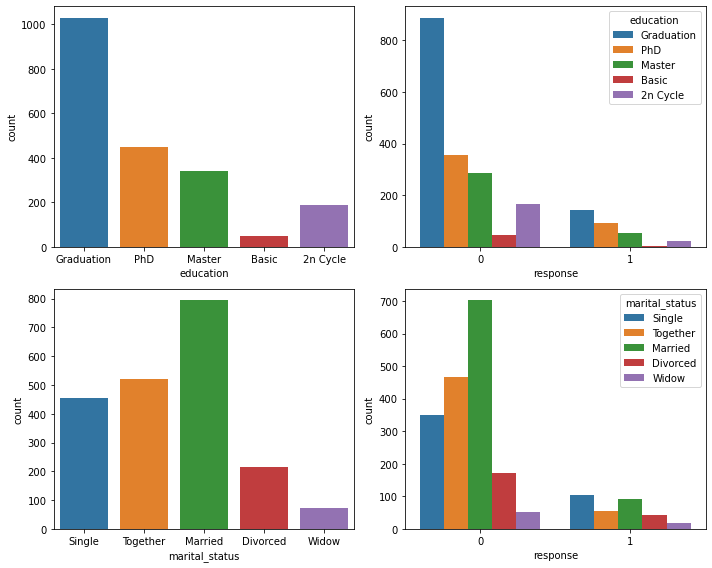

In [62]:
plt.figure(figsize=(10,8))

# categorical attribute 1
plt.subplot( 2, 2, 1 )
sns.countplot(ifood['education'])

plt.subplot( 2, 2, 2 )
sns.countplot(x='response', hue='education', data=ifood)

# categorical attribute 2
plt.subplot( 2, 2, 3 )
sns.countplot(ifood['marital_status'])

plt.subplot( 2, 2, 4 )
sns.countplot(x='response', hue='marital_status', data=ifood)
plt.tight_layout()

## 5.2 Bivariate Analysis

In [63]:
ifood_accepted = ifood[ifood['response'] == 1]

### _5.2.1. Type of Product._

During descriptive statistics (1.5.1. Numerical Attributes) We saw positive skews, then let's use the median to calculate which type of products usually brings more revenue.

- What type of product brings more revenue?
   
        Wine. People usually spend more on wine, and then meat.
        Gains are about 26 thousand each month (throughout the 
        2 years).
   
- Among those who accepted:
        
        Same conclusion for those who accepted last campaign.
        With those being responsible for about 24% of wine 
        monthly revenue.

In [64]:
# columns_used = ['mnt_wines', 'mnt_fruits']
# sns.heatmap( ifood[columns_used].corr( method='pearson' ), annot=True );

In [65]:
product_cols = ['mnt_wines','mnt_fruits','mnt_meat_products','mnt_fish_products','mnt_sweet_products','mnt_gold_prods']
# ifood_accepted[product_cols].hist(); # Also Positive Skew

In [66]:
df = ifood[product_cols]
higher_revenue_product = calculate_median_sum(df)
higher_revenue_product.index = ['wine', 'meat', 'gold_prods', 'fish', 'fruits', 'sweet']
higher_revenue_product.drop('gold_prods') # Subcategory within those

,median,sum,per_month
wine,174.0,625144,26047.67
meat,67.0,345062,14377.58
fish,12.0,76801,3200.04
fruits,8.0,53981,2249.21
sweet,8.0,55913,2329.71


per_month here means dividing by 24 months, even though there are customers with different enrollment times.

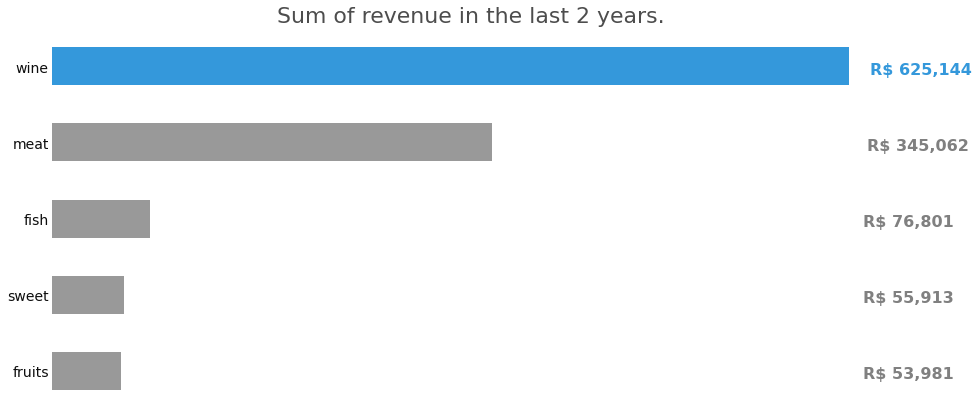

In [67]:
aux = higher_revenue_product['sum'].drop('gold_prods')
x = aux.index.values
y = aux.values
plt.figure(figsize=(15,7))
plt.box(False)
ax = (aux.sort_values() * 100).plot(kind='barh', color=[grey, grey, grey, grey, blue])
plt.tick_params(axis='both', which='both', length=0)
plt.title("Sum of revenue in the last 2 years.", size=22, color=title_grey)
plt.yticks(size=14, color=strong_grey)
_ = "  " *72
for i, v in enumerate(np.sort(y)):
    c =  blue if i == 4 else 'grey'
    ax.text(v, i-0.1, '_R$ {:2,}'.replace('_',_).format(v), color=c, fontweight='bold', size=16)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.axes.get_xaxis().set_visible(False)
plt.show()

Using the mean enrollment time there's a slightly difference... but the relation is similar.

11.81611543450065


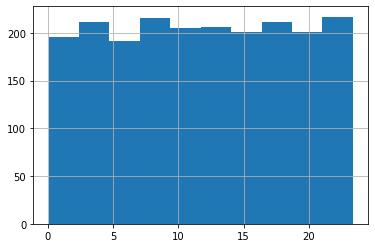

In [68]:
print( ifood['loyalty_time_months'].mean() )
ifood['loyalty_time_months'].hist();

In [69]:
# 2000 customers
higher_revenue_product['median'] * 2000 / 11

wine          31636.363636
meat          12181.818182
gold_prods     4363.636364
fish           2181.818182
fruits         1454.545455
sweet          1454.545455
Name: median, dtype: float64

Among those who accepted

In [70]:
df = ifood_accepted[product_cols]
higher_revenue_product_acc = calculate_median_sum(df)
higher_revenue_product_acc.drop('mnt_gold_prods')

,median,sum,per_month
mnt_wines,442.5,154214,6425.58
mnt_meat_products,164.5,92364,3848.50
mnt_fish_products,24.5,15956,664.83
mnt_fruits,21.0,12027,501.12
mnt_sweet_products,20.5,12146,506.08


In [71]:
higher_revenue_product_acc.loc['mnt_wines', 'per_month'] / higher_revenue_product.loc['wine', 'per_month']

0.246685404107162

People usually use 50% of what they spend on wine.

In [72]:
spent_percentage_cols = ['spent_percentage_wines', 'spent_percentage_fruits', 'spent_percentage_meat', 'spent_percentage_fish',
                         'spent_percentage_sweet', 'spent_percentage_gold']

spent_perc_desc = ifood[spent_percentage_cols].describe().T

def style_specific_cell(x):
    df = pd.DataFrame('', index=x.index, columns=x.columns)
    
    df.iloc[0:5, 0] = df.iloc[-1, -3] = 'background-color: lightblue'    
    return df

spent_perc_desc.drop(columns='count').style.apply(style_specific_cell, axis=None).format("{:.2f}")

,mean,std,min,25%,50%,75%,max
spent_percentage_wines,0.51,0.24,0.00,0.33,0.52,0.70,0.97
spent_percentage_fruits,0.06,0.07,0.00,0.01,0.03,0.08,0.76
spent_percentage_meat,0.28,0.14,0.00,0.18,0.27,0.38,1.00
spent_percentage_fish,0.08,0.10,0.00,0.01,0.05,0.12,0.75
spent_percentage_sweet,0.06,0.08,0.00,0.01,0.04,0.08,0.96
spent_percentage_gold,0.16,0.26,0.00,0.04,0.09,0.20,8.45


spent_percentage_gold is highly skewed, that's why We use median.

In [73]:
ifood[spent_percentage_cols].skew().T

spent_percentage_wines     -0.123443
spent_percentage_fruits     2.452677
spent_percentage_meat       0.622518
spent_percentage_fish       2.285430
spent_percentage_sweet      3.492782
spent_percentage_gold      16.801036
dtype: float64

In [74]:
spent_perc_desc.index = ['wine spending', 'fruits spending', 'meat spending', 'fish spending', 'sweet spending', 'gold spending']

In [75]:
spent_perc_desc.drop('gold spending')['mean'].sum() # gold is a subcategory within those

1.0000000000000009

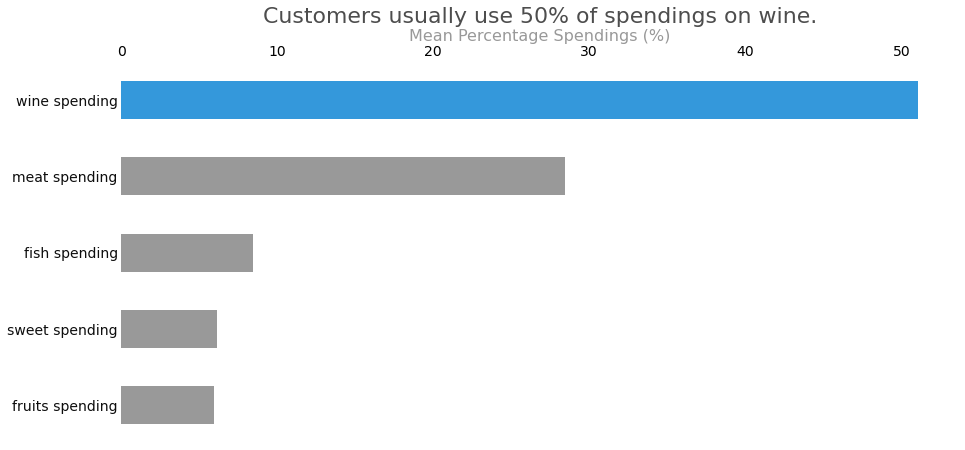

In [76]:
plt.figure(figsize=(15,7))
plt.box(False)
ax = (spent_perc_desc.drop('gold spending')['mean'].sort_values() * 100).plot(kind='barh', color=[grey, grey, grey, grey, blue])
plt.tick_params(axis='both', which='both', length=0)
plt.title("Customers usually use 50% of spendings on wine.", size=22, color=title_grey)
plt.xlabel("Mean Percentage Spendings (%)", color=grey, size=16)
plt.yticks(size=14, color=strong_grey)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(size=14)
plt.show()

- What type of product brings more revenue in web purchases?
- What type of product brings more revenue in store purchases?
- What type of product brings more revenue in catalog purchases?
- What type of product brings more revenue in discount purchases?

> _We can not answer those questions. We need data about where/how each product were bought. At the moment, they're all jointed, We know determined person spent about X in some product, but We don't know how did he get it. A query on the database (data lake) would probably solve this issue._

### _5.2.2. Type of Purchase._

**_1. Web purchases bring more revenue than purchases made in stores._**

> **No, store purchases usually have more gains.**

    Probably because in the beginnig (2011 - 2014) people didn't trust the delivery service?

**_How does this affects the company, in terms of revenue?_**

> **The current expected month gains (for 2015) are about  R$ 170,000.**
>
> **(in the best case scenario)**
>
> **Store purchases are responsible for 44% of revenue**
>
> **(29% comes from Web)**
>
> ---
>
> **With a more realistic approach and replacing the**
>
> **outliers, a better estimation is about R\$ 85,000.**
>
> What give us a revenue of about R\$ 42.5 for customer (each month).
>
> 85000/2000 = 45.2

In [77]:
amount_month = ifood['mean_amount_spent_per_month']

web_revenue_month   = ifood['percentage_web_purchases'] * amount_month
store_revenue_month = ifood['percentage_store_purchases'] * amount_month
catalog_revenue_month = ifood['percentage_catalog_purchases'] * amount_month

Revenue per month


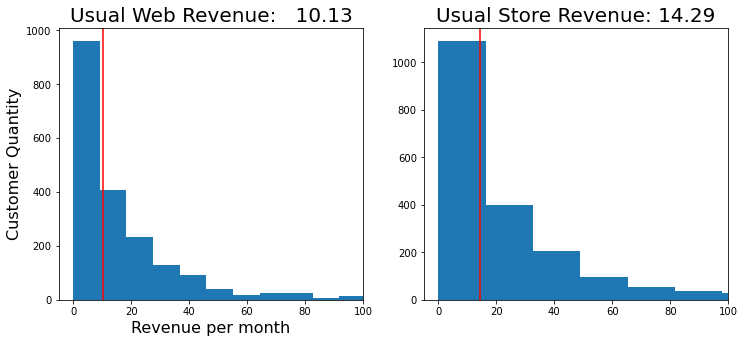

In [78]:
plt.figure(figsize=(12, 5))
print("Revenue per month")
plt.subplot(1, 2, 1)
web_revenue_month.hist(bins=60)
plt.xlim(-5, 100)
plt.title(f"Usual Web Revenue:   {round(web_revenue_month.median(), 2)}", size=20)
plt.ylabel("Customer Quantity", size=16)
plt.xlabel("Revenue per month", size=16)
plt.axvline(web_revenue_month.median(), color='r')
plt.grid(None)
plt.subplot(1, 2, 2)
store_revenue_month.hist(bins=60)
plt.axvline(store_revenue_month.median(), color='r')
plt.xlim(-5, 100)
plt.title(f"Usual Store Revenue: {round(store_revenue_month.median(), 2)}", size=20)
plt.grid(None)
plt.show()

In [79]:
## catalog_revenue_month R$ 4.30
# store_revenue_month.hist(bins=60)
# plt.axvline(catalog_revenue_month.median(), color='r')
# plt.xlim(-5, 100)
# plt.title(f"Usual Catalog Revenue: {round(catalog_revenue_month.median(), 2)}", size=20)
# plt.grid(None)
# plt.show()

In [80]:
print(f"Current Estimated Month Gains: {round( amount_month.sum(), 2)}")
print(f"store_revenue_month:   {round( store_revenue_month.sum(), 2)}")
print(f"web_revenue_month:     {round( web_revenue_month.sum(), 2)}")
print(f"catalog_revenue_month: {round( catalog_revenue_month.sum(), 2)}")
# print(f"deals_revenue_month:   {round( deals_revenue_month.sum(), 2)}")

Current Estimated Month Gains: 171077.59
store_revenue_month:   75638.53
web_revenue_month:     50443.4
catalog_revenue_month: 44975.89


In [81]:
print(f"Store { store_revenue_month.sum() / amount_month.sum()}")
print(f"Web   { web_revenue_month.sum()  / amount_month.sum()}")

Store 0.4421299814996085
Web   0.2948568344443753


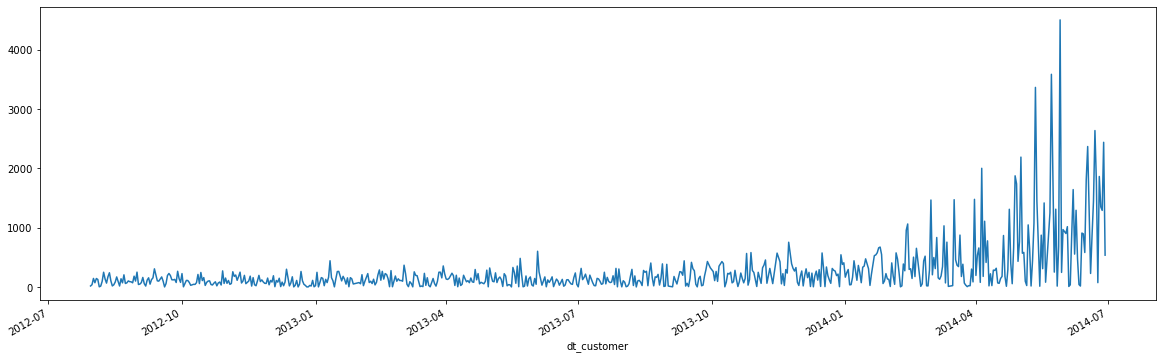

In [82]:
revenue_per_day = ifood.groupby('dt_customer')['mean_amount_spent_per_month'].sum()
plt.figure(figsize=(20, 6))
revenue_per_day.plot()
plt.show()

In [83]:
revenue_per_day.index = revenue_per_day.index.to_period('m')

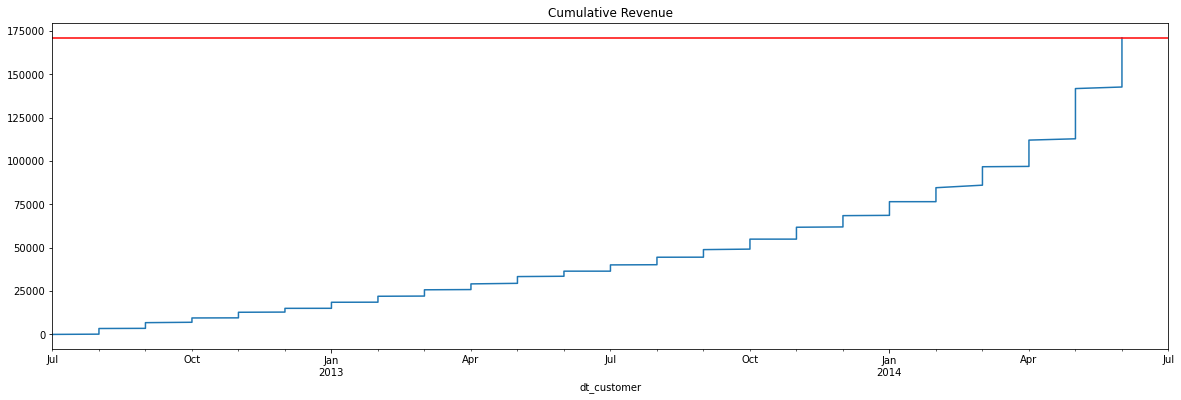

In [84]:
plt.figure(figsize=(20, 6))
revenue_per_day.cumsum().plot()
plt.axhline(171077.59, color='r')
plt.xlim('2012-07', '2014-07')
plt.title("Cumulative Revenue")
plt.show()

In [85]:
ifood[ ifood['dt_customer'] < ('2012-08-30 00:00:00')]['mean_amount_spent_per_month'].sum() # July is not R$ 0

3106.738072630219

In [86]:
ifood['mean_amount_spent_per_month'].sum()

171077.59447230762

**Outliers...**

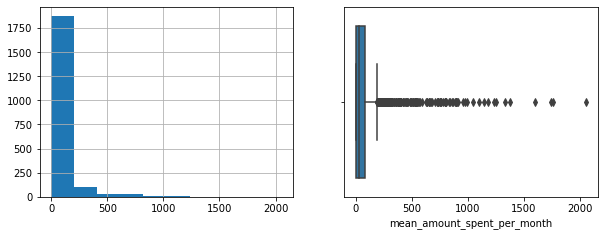

In [87]:
plt.figure(figsize=(10,3.5))
plt.subplot(1, 2, 1)
ifood['mean_amount_spent_per_month'].hist()
plt.subplot(1, 2, 2)
sns.boxplot( ifood['mean_amount_spent_per_month']);

**If we remove them, we might have a more realistic result.**

In [88]:
ifood[ifood['mean_amount_spent_per_month'] < 200]['mean_amount_spent_per_month'].sum()

79242.23580152201

**Better, instead of removing them, let's transform them into a usual customer.**

- Using the median value, instead of the outlier values.

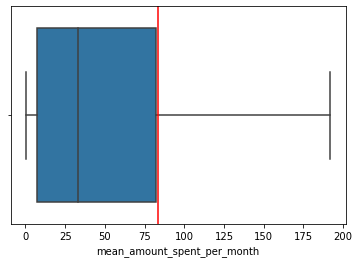

In [89]:
sns.boxplot( ifood['mean_amount_spent_per_month'], showfliers=False )
plt.axvline( ifood['mean_amount_spent_per_month'].mean(), color='r' );

In [90]:
aux = ifood.copy()
median_value = aux['mean_amount_spent_per_month'].median()
outlier = 200
aux['mean_amount_spent_per_month'] = aux['mean_amount_spent_per_month'].apply(lambda x: x if x < outlier else median_value)
aux['mean_amount_spent_per_month'].agg(['sum','mean','median'])

sum       85344.129458
mean         41.509791
median       32.974813
Name: mean_amount_spent_per_month, dtype: float64

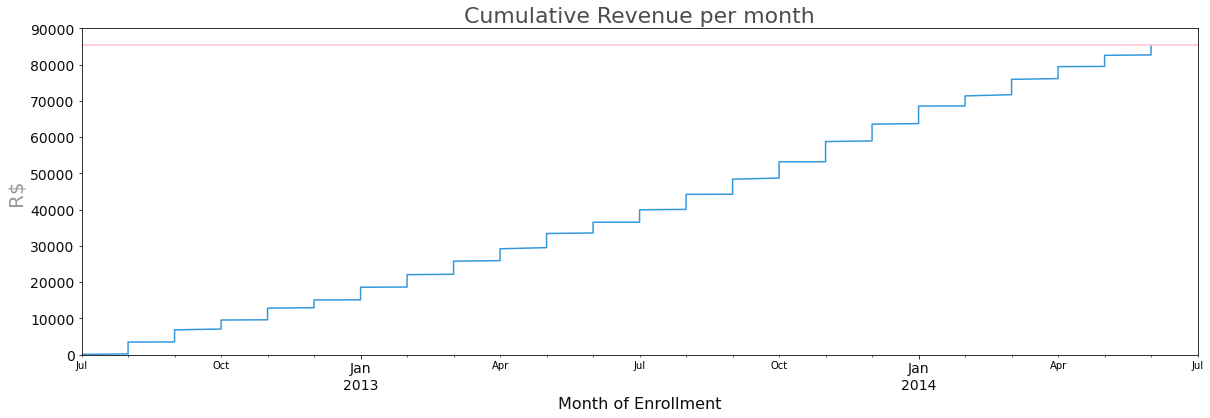

In [91]:
less_outlier = aux.copy()
revenue_per_day = less_outlier.groupby('dt_customer')['mean_amount_spent_per_month'].sum()
revenue_per_day.index = revenue_per_day.index.to_period('m')

plt.figure(figsize=(20, 6))
revenue_per_day.cumsum().plot(color=blue)
plt.axhline(revenue_per_day.sum(), color='pink')
plt.xlim('2012-07', '2014-07')
plt.title("Cumulative Revenue per month", size=22, color=title_grey)
plt.xlabel("Month of Enrollment",size=16, color=strong_grey)
plt.xticks(size=14, color=strong_grey)
plt.yticks(size=14, color=strong_grey)
plt.ylabel("R$", size=20, color=grey)
plt.ylim(0,90000)
plt.show()

In [92]:
# ifood['recency'].hist()
# plt.axvline(ifood['recency'].mean(), color='r')

In [93]:
# print("Quantile 30%: ", np.quantile(ifood['recency'], .32))
# print("Quantile 61%: ", np.quantile(ifood['recency'], .61))
# print("Quantile 91%: ", np.quantile(ifood['recency'], .91))

In [94]:
# 85 25 25 50 60 25 50 25 60 50 25 25 85
# print('Every Month   ', 85000*.3)
# print('Each 2 Months ', 85000*.3)
# print('Each 3 Months ', 85000*.4)

In [95]:
# np.mean([25, 25, 50, 60, 25, 50, 25, 60, 50, 25, 25, 85])

**accepted**

34231.810570577974

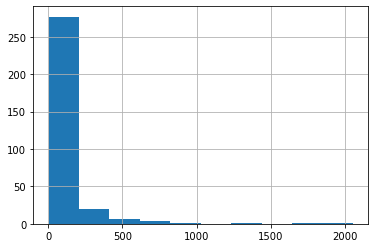

In [96]:
ifood_accepted['mean_amount_spent_per_month'].hist();
ifood_accepted['mean_amount_spent_per_month'].sum()

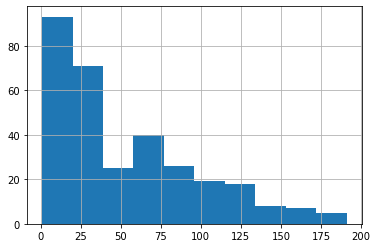

In [97]:
aux = ifood_accepted.copy()
aux['mean_amount_spent_per_month'] = aux['mean_amount_spent_per_month'].apply(lambda x: x if x < outlier else median_value)
aux['mean_amount_spent_per_month'].hist();

In [98]:
aux['mean_amount_spent_per_month'].agg(['sum','mean','median'])

sum       16519.010120
mean         52.945545
median       35.256207
Name: mean_amount_spent_per_month, dtype: float64

48.992217898832685

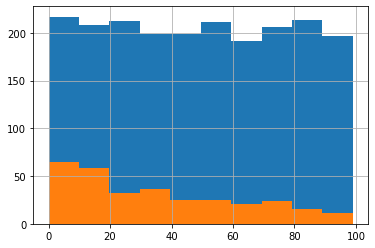

In [99]:
ifood.recency.hist();
aux.recency.hist();
ifood.recency.mean()

**_2. More discounts are made in Web purchases.._**

    We need different data to say whether that hypothesis is right. Because we don't know if the discount purchases
    were made through web, catalog or store.
    
    Anyways, 18% of the purchases made have some discount. 
    ps: I can't tell if num_purchases is related to "2 years" as in MntFishProducts, MntMeatProducts, etc...


In [100]:
ifood['num_deals_purchases'].sum()/ifood['num_purchases'].sum()

0.18648606690988123

In [101]:
ifood_accepted['num_deals_purchases'].sum()/ifood_accepted['num_purchases'].sum()

0.1519916142557652

**_3. More catalog purchases are made in Stores.._**

    We also need different data to confirm this.
    
    21% of purchases comes from catalogues.

In [102]:
ifood['num_catalog_purchases'].sum()/ifood['num_purchases'].sum()

0.212489327020104

In [103]:
ifood_accepted['num_catalog_purchases'].sum()/ifood_accepted['num_purchases'].sum()

0.27358490566037735

Counting

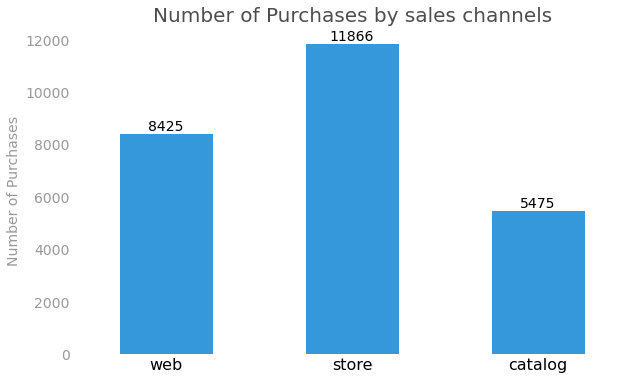

In [104]:
aux = ifood[['num_web_purchases', 'num_store_purchases', 'num_catalog_purchases' ]]
aux.columns = ['web', 'store', 'catalog']
aux = aux.sum()
x = [0,1,2]#aux.index.values
y = aux.values

plt.figure(figsize=(10, 6))
plt.box(False)
aux.plot(kind='bar', color=blue)
plt.xticks(rotation=0, size=16)
plt.title("Number of Purchases by sales channels", color=title_grey, size=20)
plt.ylabel("Number of Purchases", size=14, color=grey)
plt.yticks(size=14, color=grey)
plt.tick_params(axis='both', which='both', length=0)
for i in range(len(y)):
    plt.annotate(str(y[i]), xy=(x[i],y[i]), ha='center', va='bottom', size=14)
plt.show()

- Which type of purchase has higher "rates of acceptance" from last campaign (response)?

        We can't answer that question, because we don't have information about what purchases
        were made during each campaign.
        
        But grouping the customers by the campaigns, the number of store purchases is always
        the highest.

> Response:
>
> **Store_purchases 40%**
>
> **Web_purchases 33%**

In [105]:
campaigns_df = []
campaigns = ['accepted_cmp1', 'accepted_cmp2', 'accepted_cmp3', 'accepted_cmp4', 'accepted_cmp5', 'response']
for campaign in campaigns:
    _df = ifood[ifood[campaign] == 1]
    accepted_num_purchases = _df['num_purchases'].sum()

    percentage_deals_purchases    = round( _df['num_deals_purchases'].sum() / accepted_num_purchases, 2)
    percentage_catalog_purchases  = round( _df['num_catalog_purchases'].sum() / accepted_num_purchases, 2)
    percentage_store_purchases    = round( _df['num_store_purchases'].sum() / accepted_num_purchases, 2)
    percentage_web_purchases      = round( _df['num_web_purchases'].sum() /  accepted_num_purchases, 2)
    
    s_deals = pd.Series(percentage_deals_purchases, name='deals_purchases%', index=[campaign] )
    s_catalog = pd.Series(percentage_catalog_purchases, name='catalog_purchases%', index=[campaign] )
    s_store = pd.Series(percentage_store_purchases, name='store_purchases%', index=[campaign] )
    s_web = pd.Series(percentage_web_purchases, name='web_purchases%', index=[campaign] )
    total_customers = pd.Series(_df.shape[0], name='total_customers', index=[campaign] )
    #amount_spent = pd.Series(_df['mean_amount_spent_per_month'].mean(), name='mean_spent_month', index=[campaign] )
    amount_spent = None
    
    campaigns_df.append( pd.concat([s_store, s_web, s_deals, s_catalog, total_customers, amount_spent], axis=1) )
    
campaigns_df = pd.concat(campaigns_df, axis=0)
campaigns_df

,store_purchases%,web_purchases%,deals_purchases%,catalog_purchases%,total_customers
accepted_cmp1,0.41,0.29,0.07,0.30,135
accepted_cmp2,0.44,0.27,0.09,0.28,26
accepted_cmp3,0.38,0.34,0.16,0.28,151
accepted_cmp4,0.45,0.32,0.14,0.23,158
accepted_cmp5,0.42,0.28,0.05,0.30,148
response,0.40,0.33,0.15,0.27,312


### _5.2.3. Customers._


**_4. Older Customers tend to accept the campaign._**

> **Yes. in the last campaign we can see that most <br>
> customers are subscribed for longer** 
>
> However, throughout the campaigns there are no trend.


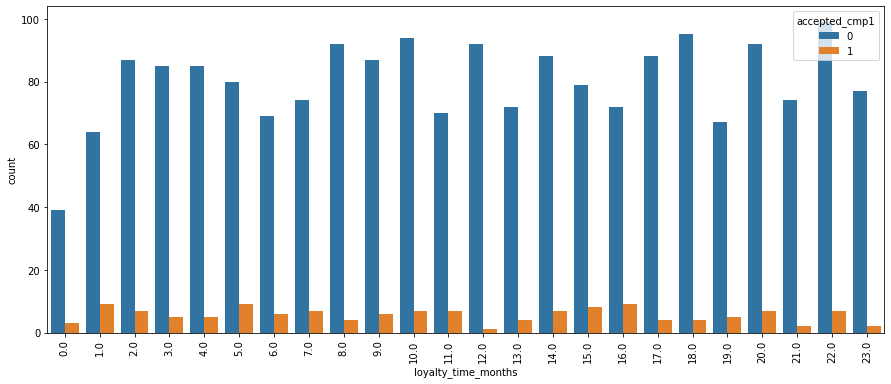

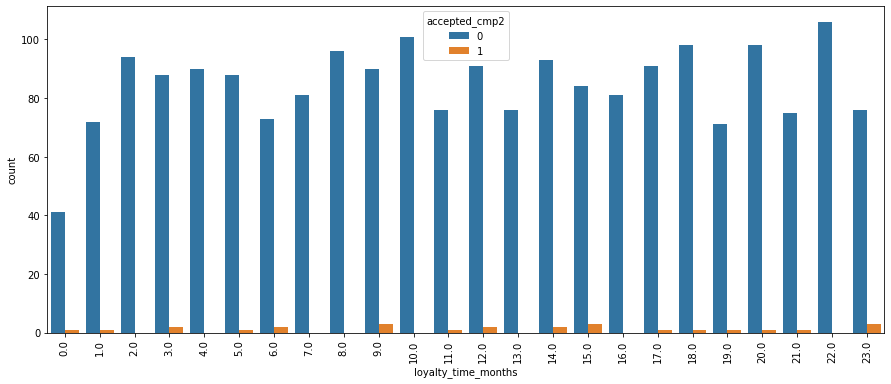

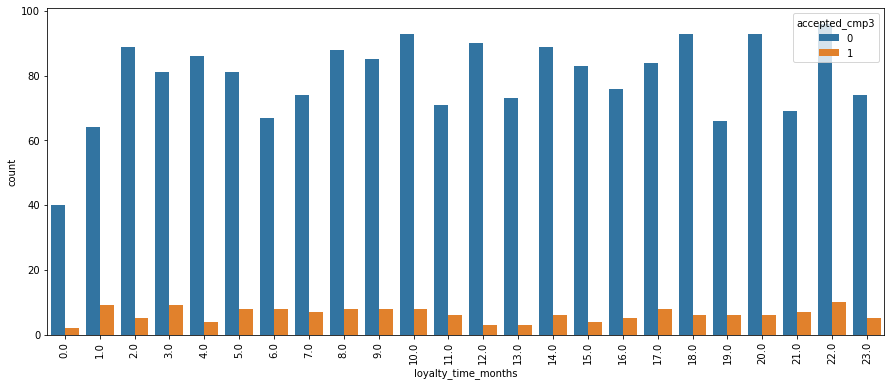

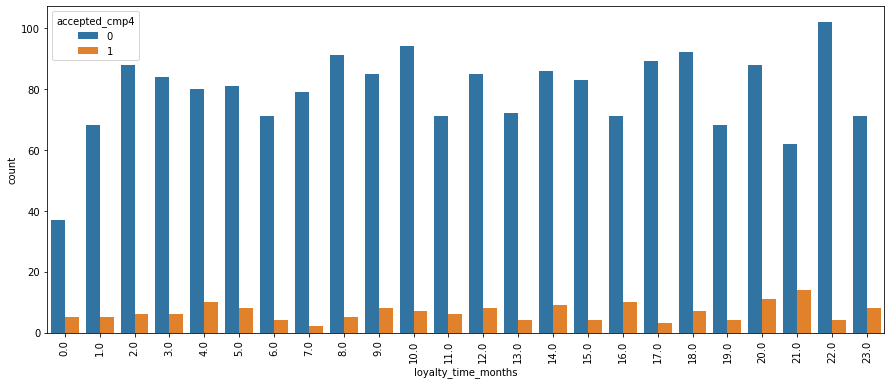

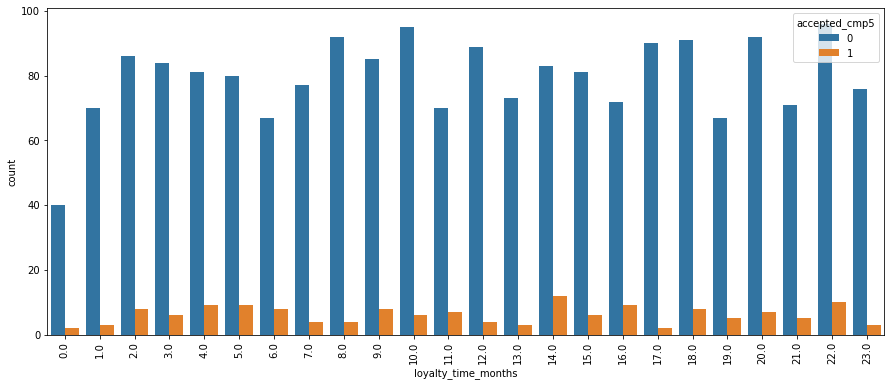

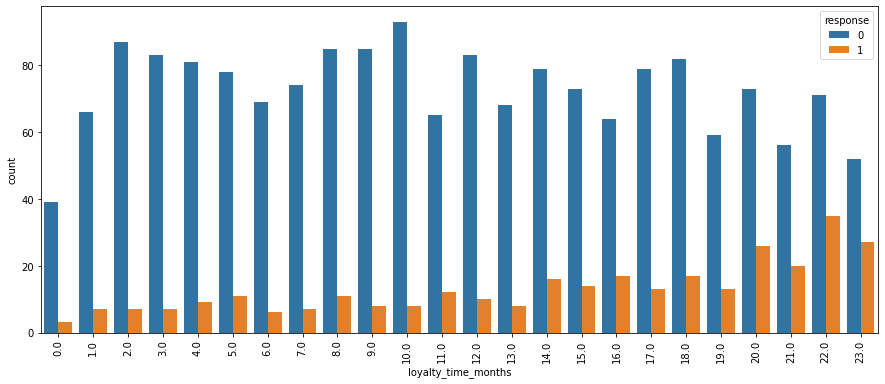

In [106]:
for campaign in campaigns:
    plt.figure(figsize=(15,6))
    sns.countplot(data=ifood, x=ifood['loyalty_time_months'].round(), hue=campaign);
    plt.xticks(rotation=90);
    plt.show()

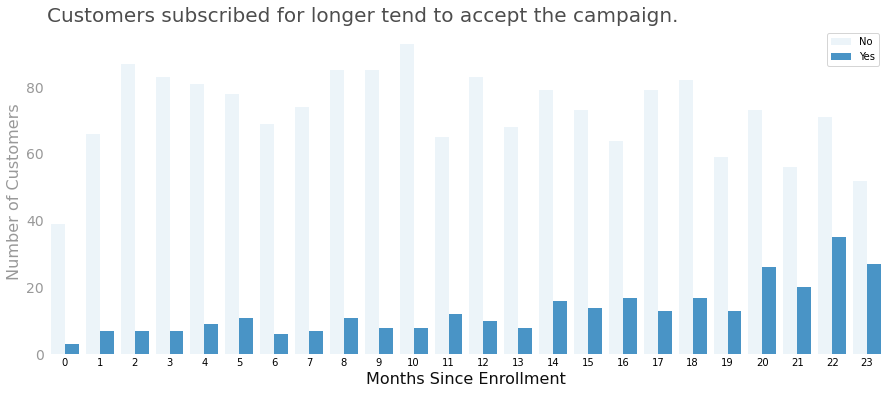

In [107]:
plt.figure(figsize=(15,6))
plt.box(False)
sns.countplot(data=ifood, x=ifood['loyalty_time_months'].round().astype(int), hue='response', color=blue);
plt.title("Customers subscribed for longer tend to accept the campaign.", size=20, color=title_grey, loc='left')
plt.xlabel("Months Since Enrollment", size=16, color=strong_grey)
plt.ylabel("Number of Customers", size=16, color=grey)
plt.legend(['No','Yes'])
plt.yticks(size=14, color=grey)
plt.tick_params(axis='both', which='both', length=0)
plt.xticks(rotation=0)
plt.show()

**_5. Older Customers bring more revenue._**

       Undefined... 

> **('-.-)**
>
> (º - º)

A drawback for this dataset is that we don't have the exactly quantity spent in each period (monthly, quarterly or annually), but the total amount for 2 years.

Then, if We use _amount_spent_ , the old customers will have spent more. And using the adapted calculus ( _mean_amount_spent_per_month_ ) new customers will show higher amounts per month.

        Time since subscription: 1 month
                    Money Spent: R$ 100
        mean_amount_spent_per_month: 100/1 = R$ 100
        
        Time since subscription: 4 month
                    Money Spent: R$ 100
        mean_amount_spent_per_month: 100/4 = R$ 25

> With the data I have now, it's hard to 
>
> believe these will be their month estimated spent.

        And for now I don't know how to deal with this...

In [108]:
c = ['dt_customer', 'amount_spent', 'loyalty_time_months', 'mean_amount_spent_per_month']
ifood.loc[ ifood['mean_amount_spent_per_month'] > 900, c ].head()

,dt_customer,amount_spent,loyalty_time_months,mean_amount_spent_per_month
53,2014-06-07,1376,0.800000,1376.000000
266,2014-06-26,1254,0.166667,1254.000000
347,2014-06-16,972,0.500000,972.000000
631,2014-06-13,909,0.600000,909.000000
924,2014-05-18,1728,1.466667,1178.181818


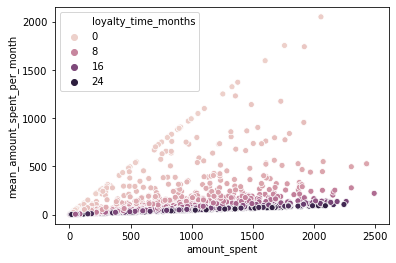

In [109]:
sns.scatterplot(ifood['amount_spent'], ifood['mean_amount_spent_per_month'], hue=ifood['loyalty_time_months']);

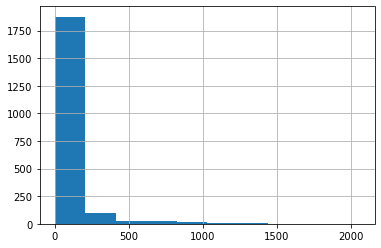

In [110]:
ifood['mean_amount_spent_per_month'].hist();

In [111]:
                                                                                                                # mean vs median
aux = pd.DataFrame( ifood.round().groupby('loyalty_time_months')[['amount_spent', 'mean_amount_spent_per_month']].mean() )
aux['amount_%'] = (aux['amount_spent'] / aux['amount_spent'].sum() * 100).round(2)
aux['mean_amount_%'] = (aux['mean_amount_spent_per_month'] / aux['mean_amount_spent_per_month'].sum() * 100).round(2)
aux['customer'] = pd.cut( aux.index, 4, labels=['newcomer', 'still_new', 'veteran', 'senior']) 
aux.groupby('customer').sum()

,amount_spent,mean_amount_spent_per_month,amount_%,mean_amount_%
customer,,,,
newcomer,2707.435810,1408.915430,20.10,62.90
still_new,3115.356034,387.185120,23.12,17.28
veteran,3479.115610,240.189572,25.83,10.72
senior,4166.670035,203.582773,30.94,9.10


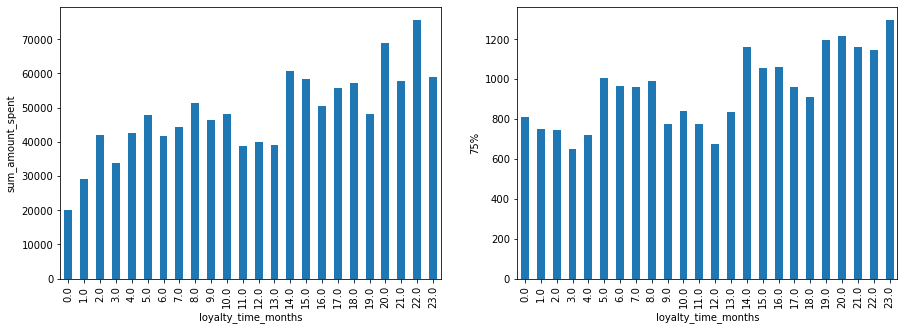

,count,mean,std,min,25%,50%,75%,max
loyalty_time_months,,,,,,,,
0.0,42.0,474.857143,549.081564,5.0,47.25,167.5,807.75,2056.0
1.0,73.0,399.315068,465.697532,7.0,33.00,262.0,747.00,1920.0
2.0,94.0,447.021277,559.854186,11.0,39.25,121.5,741.75,1916.0
3.0,90.0,375.844444,496.367500,8.0,40.25,70.5,650.00,1738.0
4.0,90.0,471.588889,565.942505,8.0,39.00,180.5,721.00,2074.0
5.0,89.0,538.808989,630.224904,5.0,42.00,221.0,1004.00,2429.0
6.0,75.0,554.680000,567.884413,12.0,51.50,389.0,965.00,1900.0
7.0,81.0,546.049383,572.750467,8.0,50.00,313.0,959.00,1903.0
8.0,96.0,533.864583,558.235182,6.0,55.25,299.5,990.00,2304.0


In [112]:
ifood_aux = ifood.copy()
ifood_aux['loyalty_time_months'] = ifood_aux['loyalty_time_months'].round()
ifood_aux = ifood_aux.groupby('loyalty_time_months')['amount_spent'] # mean_amount_spent_per_month graph trend inverts radically

# # Similar Distibutions
# for months in ifood_aux:
#     print(months[0])
#     months[1].hist()
#     plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
ifood_aux.sum().plot(kind='bar')
plt.ylabel("sum_amount_spent")

plt.subplot(1, 2, 2)
ifood_aux.describe()['75%'].plot(kind='bar');
plt.ylabel("75%")

plt.show()
ifood_aux.describe()

**_6. Customers with no complaints tend to accept the campaign._**

> **Yes**, 99% of people who accepted the campaign hadn't complained.
>
> Though it's a really small amount of complaints (20).

In [113]:
ifood['complain'].sum()

20

In [114]:
ifood.groupby('complain')['response'].sum()

complain
0    309
1      3
Name: response, dtype: int64

In [115]:
309/ifood.response.sum()

0.9903846153846154

In [116]:
ifood.groupby('complain')['response'].agg(['count','sum'])

,count,sum
complain,,
0,2036,309
1,20,3


**_7. Customers with no complaints bring more revenue._**

> **Yes.**

In [117]:
ifood.groupby('complain')[['amount_spent', 'mean_amount_spent_per_month']].mean()

,amount_spent,mean_amount_spent_per_month
complain,,
0,564.647348,83.704994
1,363.950000,32.711321


In [118]:
less_outlier.groupby('complain')[['amount_spent', 'mean_amount_spent_per_month']].mean()

,amount_spent,mean_amount_spent_per_month
complain,,
0,564.647348,41.690097
1,363.950000,23.154599


**_8. Customers who buy more frequently tend to accept the campaign._**

        No data about the frequency or dates of purchases.

**_9. Customers who buy more frequently bring more revenue._**

         No data about the frequency or dates of purchases.

However, people who have made a purchase recently were prone to accept the campaign. 

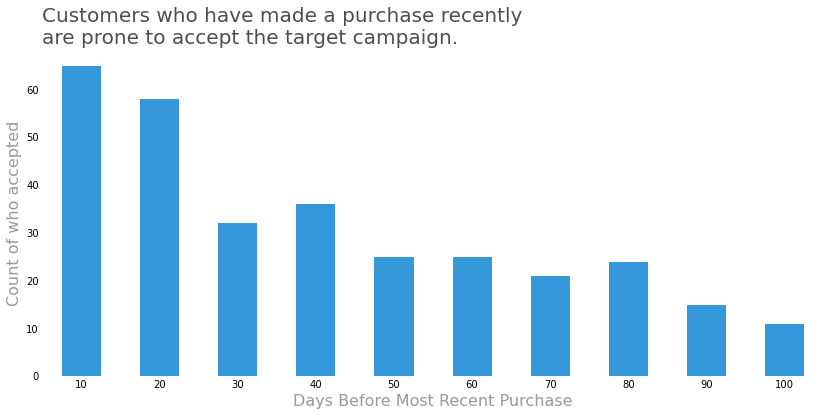

In [119]:
aux = ifood.copy()
labels = [10,20,30,40,50,60,70,80,90,100]
aux['recency_cat'] = pd.cut(aux['recency'], 10, precision=1, labels=labels)

plt.figure(figsize=(14,6))
plt.box(False)
aux.groupby('recency_cat')['response'].sum().plot(kind='bar', color=blue)
plt.title("Customers who have made a purchase recently\nare prone to accept the target campaign.",
          size=20, color=title_grey, loc='left')
plt.ylabel("Count of who accepted", size=16, color=grey)
plt.xlabel("Days Before Most Recent Purchase", size=16, color=grey)
plt.xticks(rotation=0)
plt.tick_params(axis='both', which='both', length=0)
plt.show()

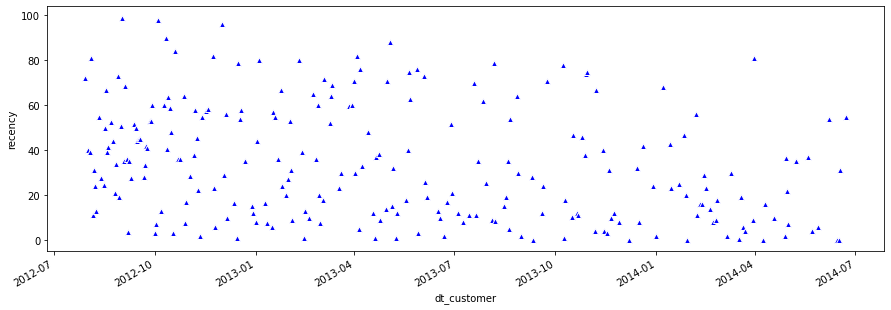

In [120]:
plt.figure(figsize=(15,5))
aux1 = aux[aux['response'] == 1]
aux1.groupby('dt_customer')['recency'].mean().plot(kind='line', color='white', marker='^', markerfacecolor='blue')
plt.ylabel("recency")
plt.show()

In [121]:
# Usually 1 observation per date
aux1.groupby('dt_customer')['recency'].count().mean()

1.2892561983471074

**_10. Customers with higher income tend to accept the campaign._**

> **Yes.** 61% of customers who accepted the campaign
>
> have an income value greater than the mean income.


    And in terms of revenue, for those who accepted the campaign, the greater the income the greater the
    amount spent.

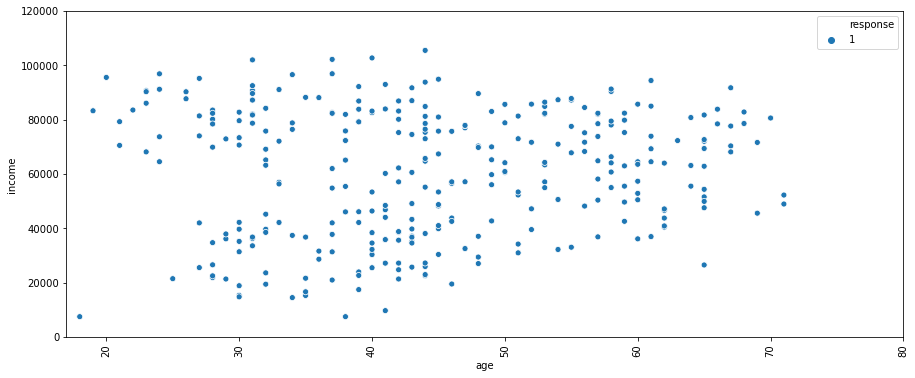

In [122]:
plt.figure(figsize=(15,6))
sns.scatterplot(data=ifood_accepted, x='age', y='income', hue='response');
plt.xticks(rotation=90);
plt.xlim(17, 80)
plt.ylim(0, 120000)
plt.show()

In [123]:
ifood[ifood['income'] >= ifood.income.mean()]['response'].sum()

193

In [124]:
ifood[ifood['income'] <= ifood.income.mean()]['response'].sum()

119

In [125]:
ifood[ifood['income'] >= ifood.income.mean()]['response'].sum() / ifood['response'].sum()

0.6185897435897436

In [126]:
aux = ifood_accepted[ifood_accepted['income'] < 200000].copy()
aux['income_cat'] = pd.cut(aux['income'], 10)
group = aux.groupby('income_cat')[['amount_spent', 'mean_amount_spent_per_month']].mean() # agg(['mean', 'count'])
group

,amount_spent,mean_amount_spent_per_month
income_cat,,
"(7402.029, 17297.1]",47.000000,5.008430
"(17297.1, 27094.2]",57.583333,4.886368
"(27094.2, 36891.3]",131.625000,10.416186
"(36891.3, 46688.4]",240.864865,22.620167
"(46688.4, 56485.5]",625.625000,48.677987
"(56485.5, 66282.6]",1028.857143,93.728741
"(66282.6, 76079.7]",1468.813953,181.091228
"(76079.7, 85876.8]",1468.564516,200.604425
"(85876.8, 95673.9]",1648.781250,209.887490


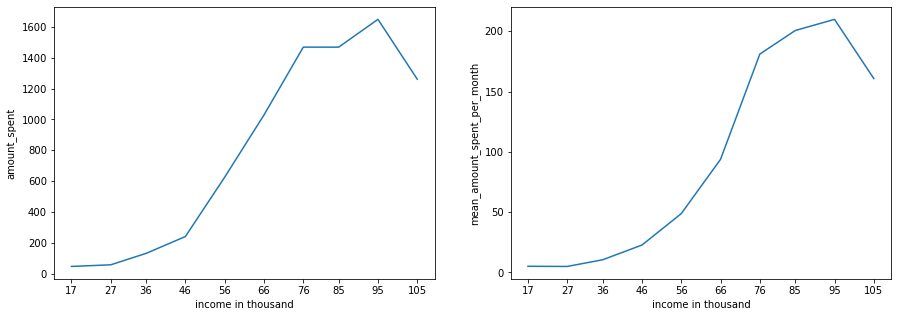

In [127]:
income_cat = [17, 27, 36, 46, 56, 66, 76, 85, 95, 105]
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.lineplot(income_cat, group.amount_spent)
plt.xticks(income_cat)
plt.xlabel('income in thousand')
plt.subplot(1, 2, 2)
sns.lineplot(income_cat, group.mean_amount_spent_per_month)
plt.xticks(income_cat)
plt.xlabel('income in thousand')
plt.show()

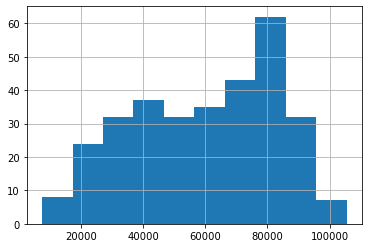

In [128]:
aux.income.hist()

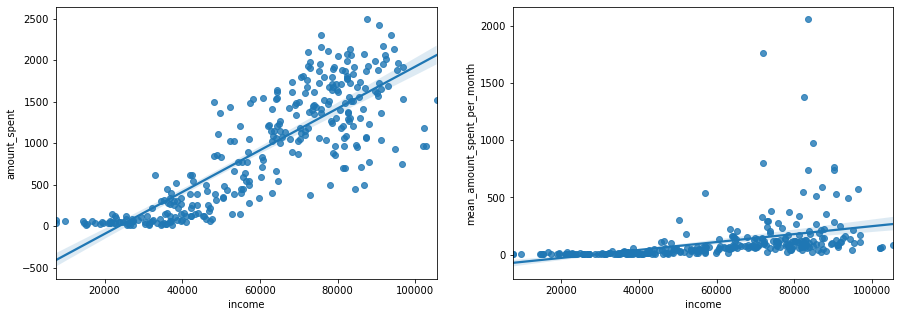

In [129]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.regplot(data=aux, x='income', y='amount_spent')
plt.subplot(1, 2, 2)
sns.regplot(data=aux, x='income', y='mean_amount_spent_per_month')
plt.show()

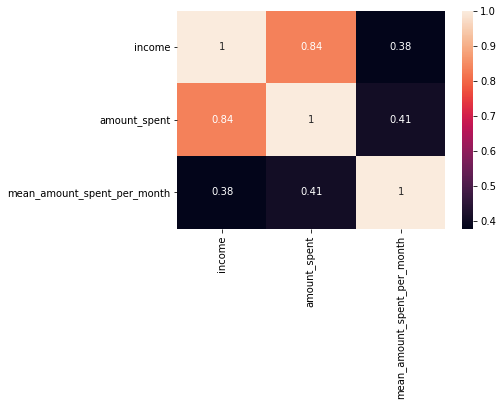

In [130]:
sns.heatmap(aux[['income','amount_spent','mean_amount_spent_per_month']].corr(), annot=True)
plt.yticks(rotation=0) 
plt.show()

**_11. Customers with higher income bring more revenue._**

> Yes, but this correlation is not as strong as expected.
>
> Which means that **in terms of revenue the difference**
>
> **may not be that large** (weak linear relationship).

    mean_amount_spent_per_month 

In [131]:
# plt.figure(figsize=(12,6))
# plt.box(False)
# sns.regplot(data=ifood, x='income', y='mean_amount_spent_per_month', scatter_kws={"color": blue}, line_kws={"color": "red"})
# plt.ylim(-100, 2200)
# plt.xlim(0, 120000)
# plt.ylabel("mean amount spent per month", size=16, color=title_grey)
# plt.xlabel("income", size=16, color=title_grey)
# plt.xticks(color=grey, size=14)
# plt.yticks(color=grey, size=14)
# plt.tick_params(axis='both', which='both', length=0)
# plt.show()

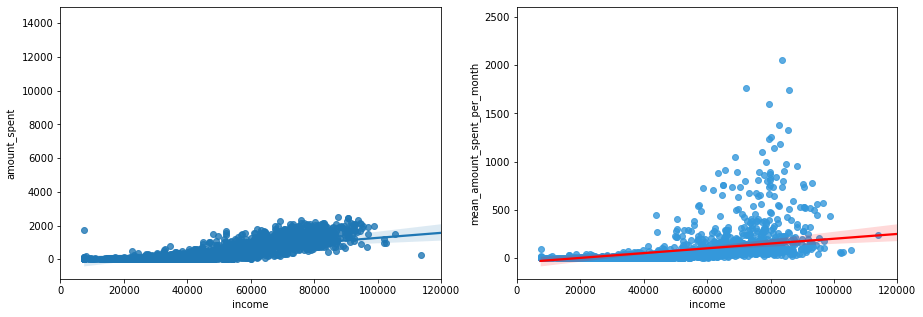

In [132]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.regplot(data=ifood, x='income', y='amount_spent')
plt.xlim(0, 120000)
plt.subplot(1, 2, 2)
sns.regplot(data=ifood, x='income', y='mean_amount_spent_per_month', scatter_kws={"color": blue}, line_kws={"color": "red"})
plt.xlim(0, 120000)
plt.show()

In [133]:
ifood.loc[ ifood['mean_amount_spent_per_month'] < 500, 'mean_amount_spent_per_month'].describe()#quantile(.90) # 144

count    1989.000000
mean       57.802164
std        77.794364
min         0.270270
25%         6.904762
50%        29.239130
75%        75.061224
max       497.266187
Name: mean_amount_spent_per_month, dtype: float64

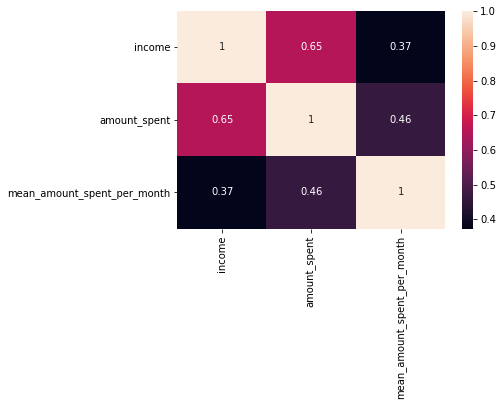

In [134]:
sns.heatmap(ifood[['income','amount_spent','mean_amount_spent_per_month']].corr(), annot=True)
plt.yticks(rotation=0) 
plt.show()

**_12. Customers with greater educational level tend to accept the campaign._**

> Yes, but not quite, half of people are graduated, then
>
> this imbalance in data kind of undo any possible trend.
>
> Using the percentage scale we can see there is a 
>
> relation, but that doesn't mean the more PHDs higher 
>
> the chance the customer will accept the campaign.

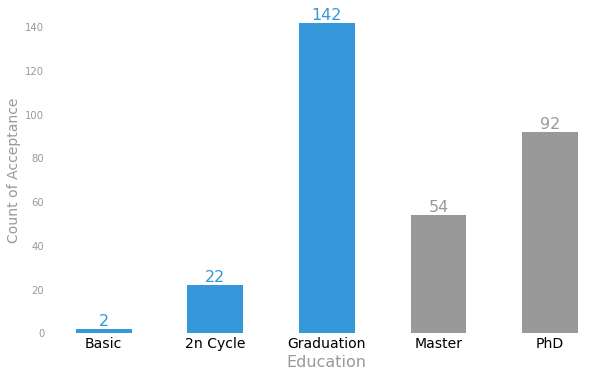

In [135]:
cats = ['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']
aux = ifood.groupby('education')['response'].sum().loc[cats]
x = [0,1,2,3,4]
y = aux.values

plt.figure(figsize=(10,6))
plt.box(False)
aux.plot(kind='bar', color=[blue, blue, blue, grey, grey])
plt.ylabel('Count of Acceptance', size=14, color=grey)
plt.xlabel("Education", size=16, color=grey)
plt.xticks(rotation=0, size=14)
plt.yticks(color=grey)
plt.tick_params(axis='both', which='both', length=0)
for i in range(len(y)):
    color = blue if i < 3 else grey
    plt.annotate(str(y[i]), xy=(x[i],y[i]), ha='center', va='bottom', color=color, size=16)
plt.show()

In [136]:
ifood['education'].value_counts(normalize=True)

Graduation    0.500486
PhD           0.218385
Master        0.165856
2n Cycle      0.091440
Basic         0.023833
Name: education, dtype: float64

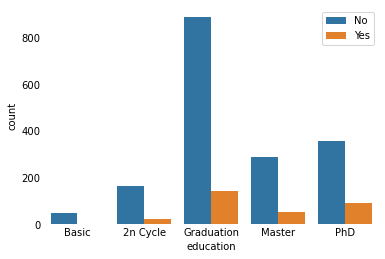

In [137]:
plt.box(False)
sns.countplot(ifood['education'], hue=ifood['response'], order=cats)
plt.legend(["No","Yes"])
plt.tick_params(axis='both', which='both', length=0)

In [138]:
aux_ = ifood.groupby('education')['response'].agg(['count','sum'])
aux_['%accepted'] = aux_['sum'] / aux_['count']
aux_ = aux_.sort_values('%accepted') 
aux_['%accepted'] = round(aux_['%accepted']*100).astype(int)
aux_

,count,sum,%accepted
education,,,
Basic,49,2,4
2n Cycle,188,22,12
Graduation,1029,142,14
Master,341,54,16
PhD,449,92,20


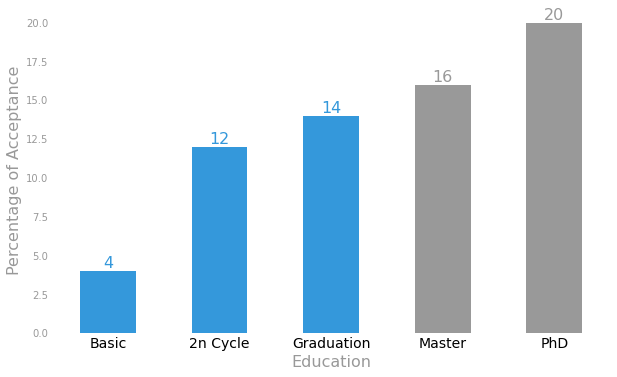

In [139]:
cats = ['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']
aux = aux_['%accepted']
x = [0,1,2,3,4]
y = aux.values

plt.figure(figsize=(10,6))
plt.box(False)
aux.plot(kind='bar', color=[blue, blue, blue, grey, grey])
plt.ylabel('Percentage of Acceptance', size=16, color=grey)
plt.xlabel("Education", size=16, color=grey)
plt.xticks(rotation=0, size=14)
plt.yticks(color=grey)
plt.tick_params(axis='both', which='both', length=0)
for i in range(len(y)):
    color = blue if i < 3 else grey
    plt.annotate(str(y[i]), xy=(x[i],y[i]), ha='center', va='bottom', color=color, size=16)
plt.show()

**_13. Customers with greater educational level bring more revenue._**

> Until a certain level we can think of that.
>
> However, after gratuate, that's not a rule.

    Customers with greater educational level tend to have greater amount_spent.

In [140]:
ifood.groupby('education')[['amount_spent','mean_amount_spent_per_month']].mean()

,amount_spent,mean_amount_spent_per_month
education,,
2n Cycle,451.223404,58.583634
Basic,61.163265,6.025344
Graduation,571.425656,88.485799
Master,579.498534,84.763570
PhD,631.331849,88.668963


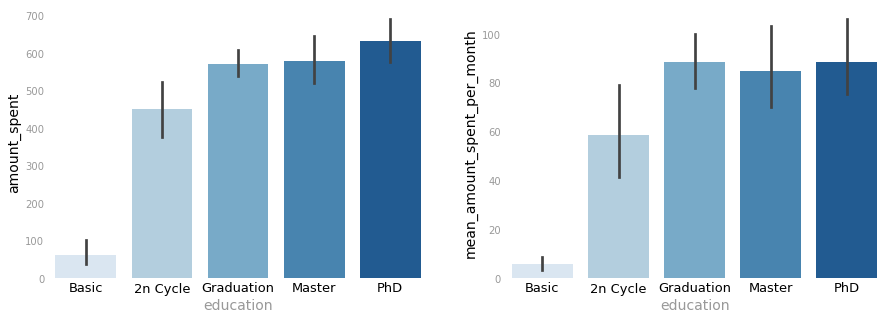

In [141]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.barplot(ifood['education'], ifood['amount_spent'], order=cats, palette='Blues')
plt.ylabel('amount_spent', size=14)
plt.xlabel('education', size=14, color=grey)
plt.yticks(color=grey)
plt.xticks(size=13)
plt.box(False)
plt.tick_params(axis='both', which='both', length=0)


plt.subplot(1, 2, 2)
sns.barplot(ifood['education'], ifood['mean_amount_spent_per_month'], order=cats, palette='Blues')
plt.ylabel('mean_amount_spent_per_month', size=14)
plt.xlabel('education', size=14, color=grey)
plt.yticks(color=grey)
plt.xticks(size=13)
plt.box(False)
plt.tick_params(axis='both', which='both', length=0)


plt.show()

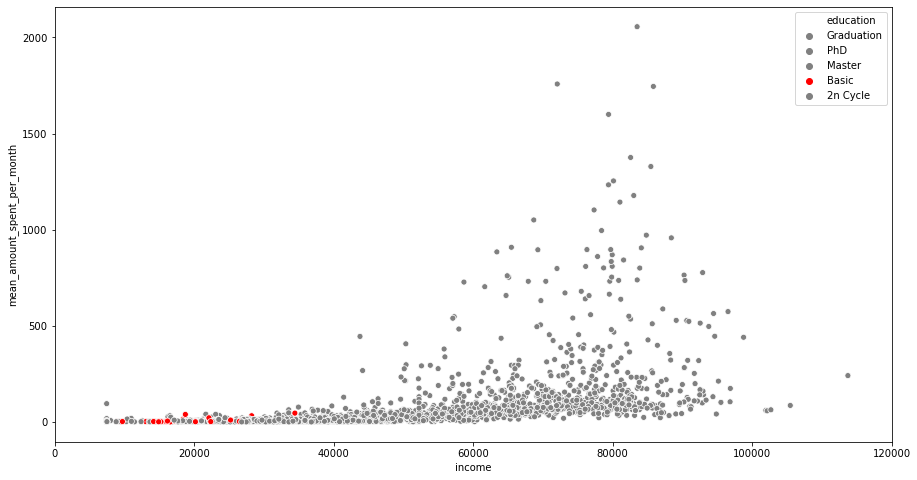

In [142]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=ifood, x='income', y='mean_amount_spent_per_month', hue='education',
                palette=['grey','grey','grey','red','grey'])
plt.xlim(0, 120000)
plt.show()

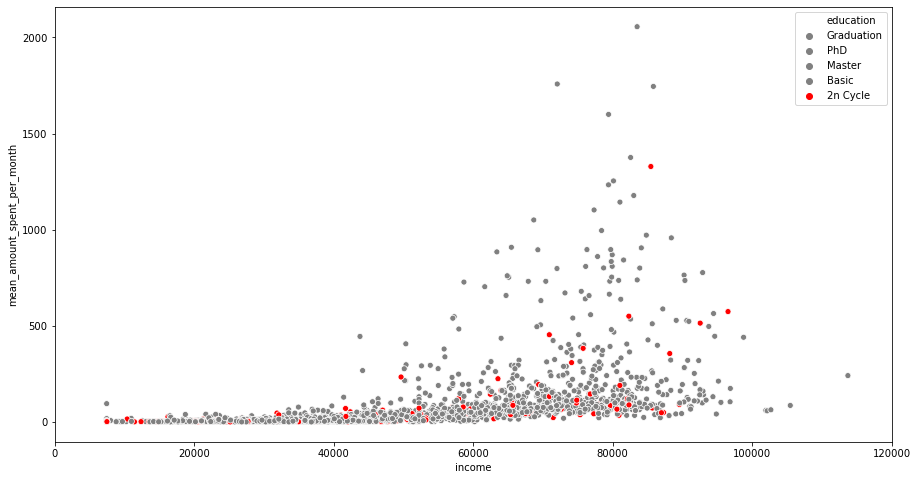

In [143]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=ifood, x='income', y='mean_amount_spent_per_month', hue='education',
                palette=['grey','grey','grey','grey','red'])
plt.xlim(0, 120000)
plt.show()

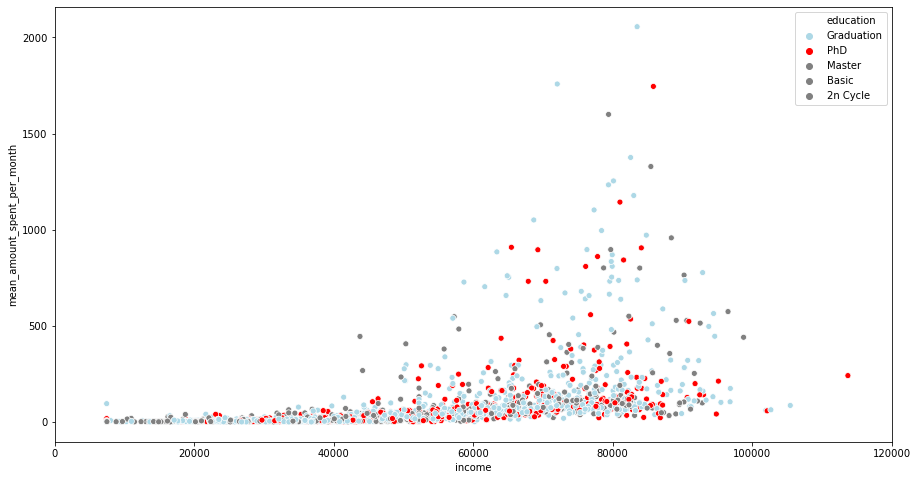

In [144]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=ifood, x='income', y='mean_amount_spent_per_month', hue='education',
                palette=['lightblue','red','grey','grey','grey'])
plt.xlim(0, 120000)
plt.show()

**_14. Customers with two kids tend to accept the campaign._**

> **No**, the more the kids the lower is the chance
>
> of acceptance.

In [145]:
aux = ifood[ifood['response'] == 1]
dependents = aux.groupby('dependents_number').dependents_number.count()
dependents

dependents_number
0    159
1    107
2     44
3      2
Name: dependents_number, dtype: int64

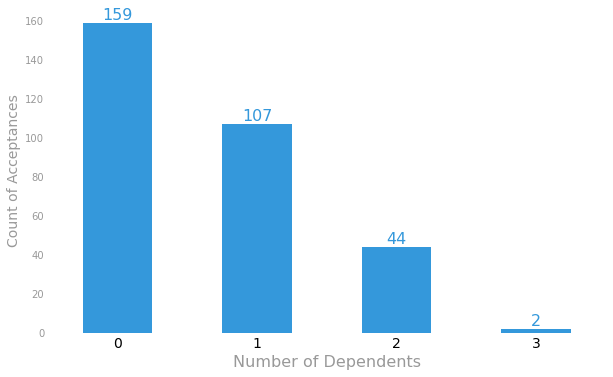

In [146]:
aux = dependents
x = [0,1,2,3]
y = aux.values

plt.figure(figsize=(10,6))
plt.box(False)
aux.plot(kind='bar', color=blue)
plt.ylabel('Count of Acceptances', size=14, color=grey)
plt.xlabel("Number of Dependents", size=16, color=grey)
plt.xticks(rotation=0, size=14)
plt.yticks(color=grey)
plt.tick_params(axis='both', which='both', length=0)
for i in range(len(y)):
    plt.annotate(str(y[i]), xy=(x[i],y[i]), ha='center', va='bottom', color=blue, size=16)
plt.show()

In [147]:
total_dependents = ifood['dependents_number'].value_counts().sort_index()
total_dependents

0     577
1    1043
2     388
3      48
Name: dependents_number, dtype: int64

In [148]:
dependents / total_dependents

dependents_number
0    0.275563
1    0.102589
2    0.113402
3    0.041667
Name: dependents_number, dtype: float64

**_15. Customers with two kids bring more revenue._**

> **No,** again, the more the kids the lower is the revenue

In [149]:
ifood.groupby('dependents_number')[['amount_spent','mean_amount_spent_per_month']].agg(['sum', 'mean','median']).round()

amount_spent                mean_amount_spent_per_month  \
                           sum    mean median                         sum   
dependents_number                                                           
0                       609754  1057.0   1117                     98491.0   
1                       448467   430.0    264                     59691.0   
2                        86179   222.0     84                     11437.0   
3                        12501   260.0     68                      1459.0   

                                 
                    mean median  
dependents_number                
0                  171.0   90.0  
1                   57.0   24.0  
2                   29.0   12.0  
3                   30.0    8.0

**_16. Single Customers tend to accept the campaign._**

> **Yes**, they're not majority, yet more of them has accepted.

Text(0.5, 0, 'Marital Status')

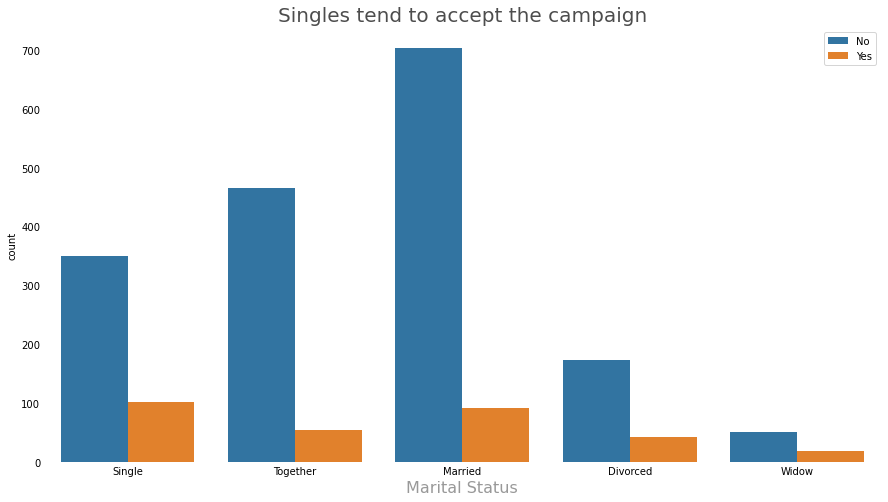

In [150]:
plt.figure(figsize=(15,8))
plt.box(False)
sns.countplot(ifood['marital_status'], hue=ifood['response'])
plt.title("Singles tend to accept the campaign", size=20, color=title_grey)
plt.legend(["No","Yes"])
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel("Marital Status", size=16, color=grey)


**_17. Single Customers bring more revenue._**

> **No**, though widows have the greatest average.

In [151]:
ifood.groupby('marital_status')[['amount_spent','mean_amount_spent_per_month']].agg(['sum', 'mean','median']).round()

amount_spent               mean_amount_spent_per_month         \
                        sum   mean median                         sum   mean   
marital_status                                                                 
Divorced             121004  560.0  346.0                     16869.0   78.0   
Married              438060  551.0  348.0                     65530.0   82.0   
Single               253588  560.0  294.0                     37039.0   82.0   
Together             294264  565.0  311.0                     43919.0   84.0   
Widow                 49985  704.0  600.0                      7719.0  109.0   

                       
               median  
marital_status         
Divorced         35.0  
Married          35.0  
Single           25.0  
Together         29.0  
Widow            46.0

In [152]:
ifood['marital_status'].value_counts().sort_values()

Widow        71
Divorced    216
Single      453
Together    521
Married     795
Name: marital_status, dtype: int64

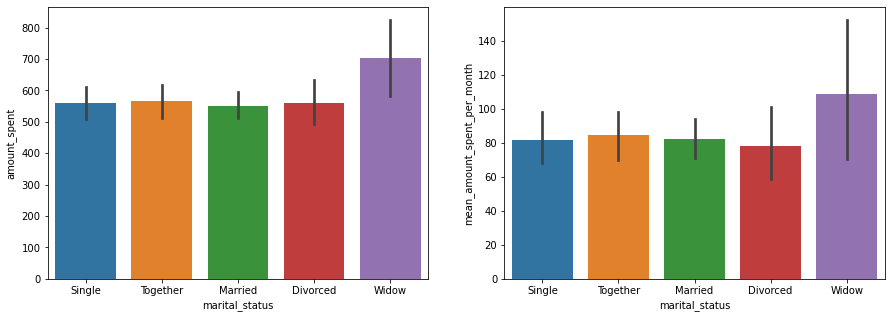

In [153]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.barplot(ifood['marital_status'], ifood['amount_spent'])
plt.subplot(1, 2, 2)
sns.barplot(ifood['marital_status'], ifood['mean_amount_spent_per_month'])
plt.show()

- Which marital status has higher rates of acceptance of the last campaign?
                           
        Widow       27%      
        Single      23%     
        Divorced    20%      
        Married     12%
        Together    11%

In [154]:
ifood.groupby('marital_status')['response'].sum()

marital_status
Divorced     43
Married      92
Single      103
Together     55
Widow        19
Name: response, dtype: int64

In [155]:
ifood['marital_status'].value_counts().sort_index()

Divorced    216
Married     795
Single      453
Together    521
Widow        71
Name: marital_status, dtype: int64

In [156]:
(ifood.groupby('marital_status')['response'].sum() / ifood['marital_status'].value_counts().sort_index()).round(2).sort_values()

marital_status
Together    0.11
Married     0.12
Divorced    0.20
Single      0.23
Widow       0.27
dtype: float64

- Which marital status has accepted more campaigns?

        Married     244
        Together    150
        Single      135
        
- Among those who accepted:

        Married     106
        Single       91
        Together     51

In [157]:
ifood.groupby('marital_status')['num_accepted_cmps'].sum()

marital_status
Divorced     62
Married     244
Single      135
Together    150
Widow        27
Name: num_accepted_cmps, dtype: int64

In [158]:
# analysis leakage?
aux = ifood.copy()
aux['num_accepted_cmps'] = aux['num_accepted_cmps'] + aux['response']
aux.groupby('marital_status')['num_accepted_cmps'].sum()

marital_status
Divorced    105
Married     336
Single      238
Together    205
Widow        46
Name: num_accepted_cmps, dtype: int64

In [159]:
ifood_accepted.groupby('marital_status')['num_accepted_cmps'].sum()

marital_status
Divorced     38
Married     106
Single       91
Together     51
Widow        19
Name: num_accepted_cmps, dtype: int64

In [160]:
# ifood.to_pickle("data/data_to_ml.pkl")

## Second Cycle

A more storytelling, playful and graphly approach. The common path here is to keep analysing and answering the hypotheses that weren't the focus on the first cycle. But I don't want to extend myself, then I'll just play a little with the data.

### Conversion Rate.

        Conversion rate = (conversions / total visitors)
        
> **77% of web convertion rate**
>
> 8425 out of 10934 web visits ended up in a purchase.

In [161]:
ifood['num_web_purchases'].sum() / ifood['num_web_visits_month'].sum()

0.7705322846167917

In [162]:
ifood['num_web_purchases'].sum()

8425

In [163]:
ifood['num_web_visits_month'].sum()

10934

### Most Revenue Comes from which range of Age? What do they buy the most?

In [164]:
age_group = ifood.groupby('age')['mean_amount_spent_per_month'].agg(['count','sum','median','mean'])

**Due to quantity, it's expected that the range(36, 45) brings more revenue.**

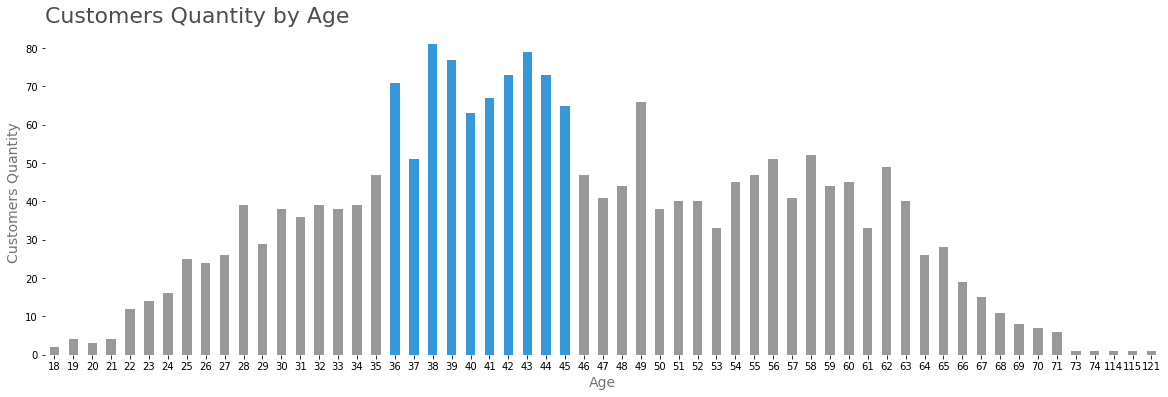

In [165]:
plt.figure(figsize=(20, 6))
plt.box(False) 

my_colors = []
for age in ifood['age'].sort_values().unique():
    if age in range(36, 46):
        my_colors.append(blue)
    else:
        my_colors.append(grey)

age_group['count'].plot(kind='bar', color=my_colors)
plt.title("Customers Quantity by Age", size=22, loc='left', color=title_grey)
plt.ylabel("Customers Quantity", size=14, color=light_grey)
plt.xlabel("Age", size=14, color=light_grey)
plt.xticks(rotation=0)

plt.show()

And yes, in terms of total money spent, they do.

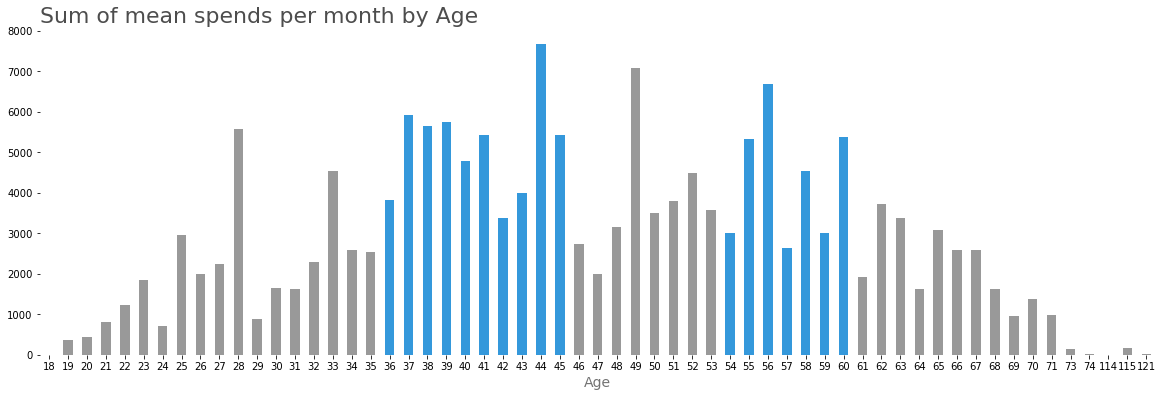

In [166]:
plt.figure(figsize=(20, 6))
plt.box(False) 
my_colors = []
for age in ifood['age'].sort_values().unique():
    if age in range(36, 46) or age in range(54, 61):
        my_colors.append(blue)
    else:
        my_colors.append(grey)

age_group['sum'].plot(kind='bar', color=my_colors)
plt.title("Sum of mean spends per month by Age", size=22, loc='left', color=title_grey)
plt.xlabel("Age", size=14, color=light_grey)
plt.xticks(rotation=0)

plt.show()

**However, the mean and median amounts spent per month show us that the youngest and elders are the ones who usually spend more.**

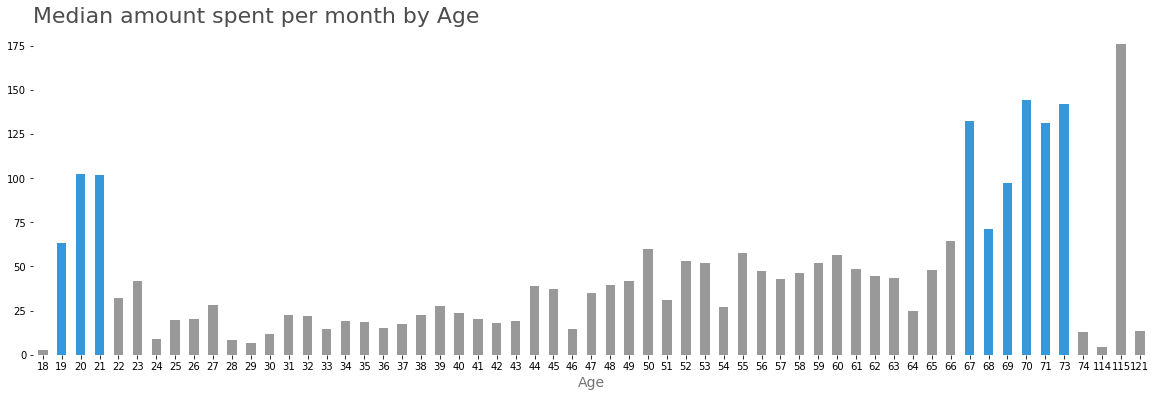

In [167]:
plt.figure(figsize=(20, 6))
plt.box(False) 
my_colors = []
for age in ifood['age'].sort_values().unique():
    if age in range(19, 22) or age in range(67, 74):
        my_colors.append(blue)
    else:
        my_colors.append(grey)
        
age_group['median'].plot(kind='bar', color=my_colors)
plt.title("Median amount spent per month by Age", size=22, loc='left', color=title_grey)
plt.xlabel("Age", size=14, color=light_grey)
plt.xticks(rotation=0)

plt.show()

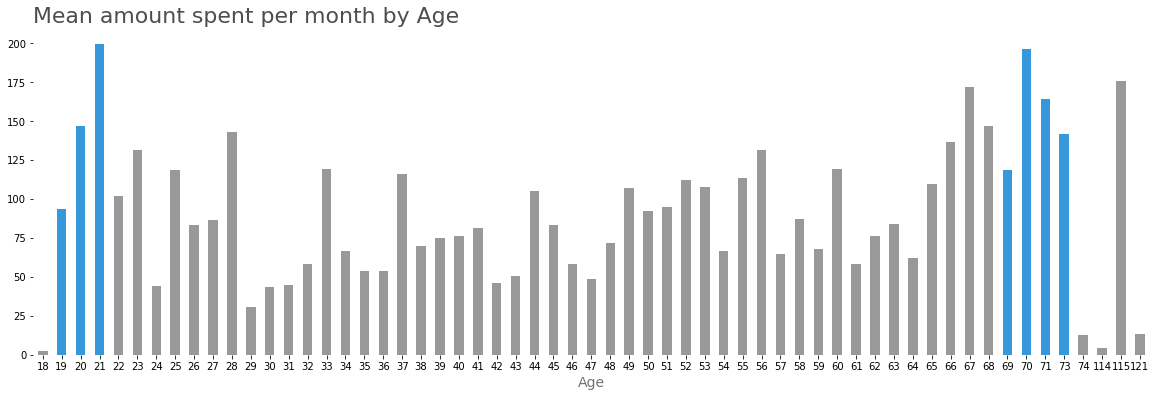

In [168]:
plt.figure(figsize=(20, 6))
plt.box(False) 
my_colors = []
for age in ifood['age'].sort_values().unique():
    if age in range(19, 22) or age in range(69, 74):
        my_colors.append(blue)
    else:
        my_colors.append(grey)
age_group['mean'].plot(kind='bar', color=my_colors)
plt.title("Mean amount spent per month by Age", size=22, loc='left', color=title_grey)
plt.xlabel("Age", size=14, color=light_grey)
plt.xticks(rotation=0)

plt.show()

#### num_purchases

**And also, older people tends to buy more products, following the youth.**

In [169]:
age_group = ifood.groupby('age')['num_purchases'].agg(['count','sum','median','mean'])

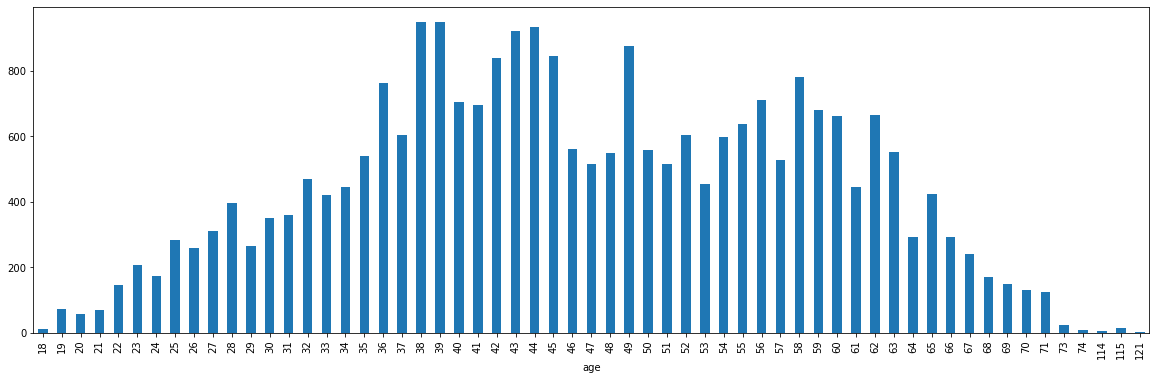

In [170]:
plt.figure(figsize=(20, 6))
age_group['sum'].plot(kind='bar');

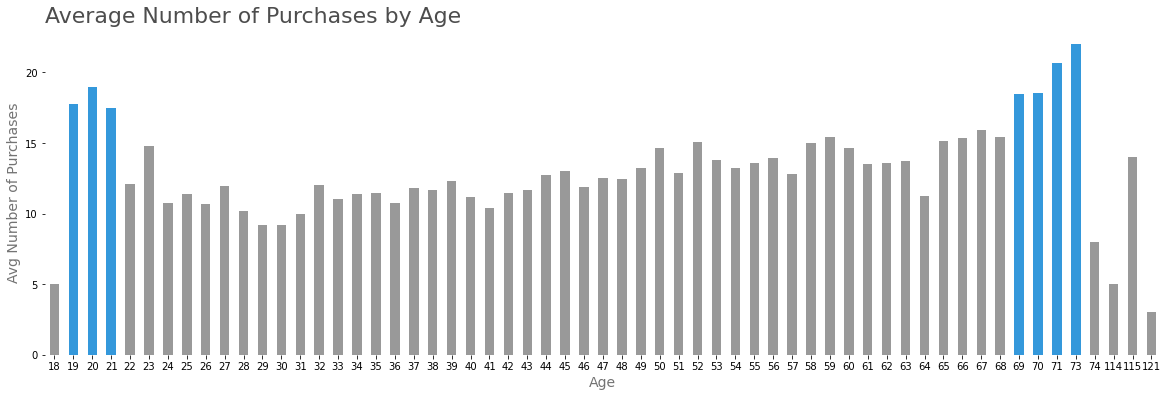

In [171]:
plt.figure(figsize=(20, 6))
plt.box(False) 

my_colors = []
for age in ifood['age'].sort_values().unique():
    if age in [19, 20, 21]:
        my_colors.append(blue)
    elif age in range(69, 74):
        my_colors.append(blue)
    else:
        my_colors.append(grey)
        
age_group['mean'].plot(kind='bar', color=my_colors)
plt.title("Average Number of Purchases by Age", size=22, loc='left', color=title_grey)
plt.ylabel("Avg Number of Purchases", size=14, color=light_grey)
plt.xlabel("Age", size=14, color=light_grey)
plt.xticks(rotation=0)

plt.show()

(17.0, 75.0)

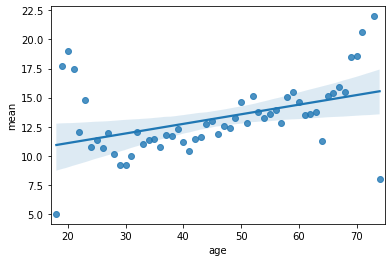

In [172]:
sns.regplot(age_group.index[:56], age_group['mean'][:56])
plt.xlim(17,75)

### What do they buy the most?

**The older the person the higher the chance wine is the preference. While the young customers like wine and meat at similar levels.**

In [173]:
age_group = ifood.groupby('age')[['spent_percentage_wines', 'spent_percentage_fruits', 'spent_percentage_meat',
                                  'spent_percentage_fish', 'spent_percentage_sweet', 'spent_percentage_gold']].mean()

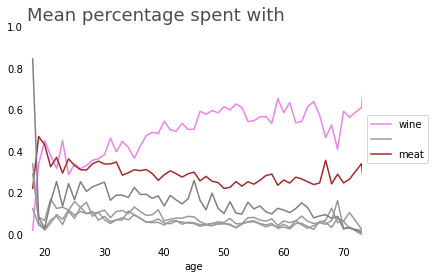

In [174]:
age_group.plot(color=['violet',grey,'brown',grey,grey,'grey'])
plt.box(False)
plt.legend(['wine','','meat'],bbox_to_anchor=(1, .35))
plt.title("Mean percentage spent with", size=18, loc='left', color=title_grey)
plt.xlim(17,73)
plt.tick_params(axis='both', which='both', length=0)
plt.show()

### Number of Dependents 

Even though there are almost the double quantity of customers with 1 dependent when compared to those who have no one, clients with no dependents bring more revenue (even in cumulative values).

In [175]:
ifood.groupby('dependents_number')['mean_amount_spent_per_month'].agg(['count','sum','mean','median'])

,count,sum,mean,median
dependents_number,,,,
0,577,98490.674521,170.694410,89.557522
1,1043,59690.609125,57.229731,24.344624
2,388,11437.096376,29.477053,12.283785
3,48,1459.214451,30.400301,8.352442


In [176]:
ifood.groupby('dependents_number')['response'].agg(['count','sum'])

,count,sum
dependents_number,,
0,577,159
1,1043,107
2,388,44
3,48,2


In [177]:
#aux = ifood_accepted.groupby('dependents_number')['mean_amount_spent_per_month'].agg(['count','sum','mean','median'])
aux = ifood_accepted.groupby('dependents_number')['response'].sum()
x = aux.index.values
y = aux.values
aux

dependents_number
0    159
1    107
2     44
3      2
Name: response, dtype: int64

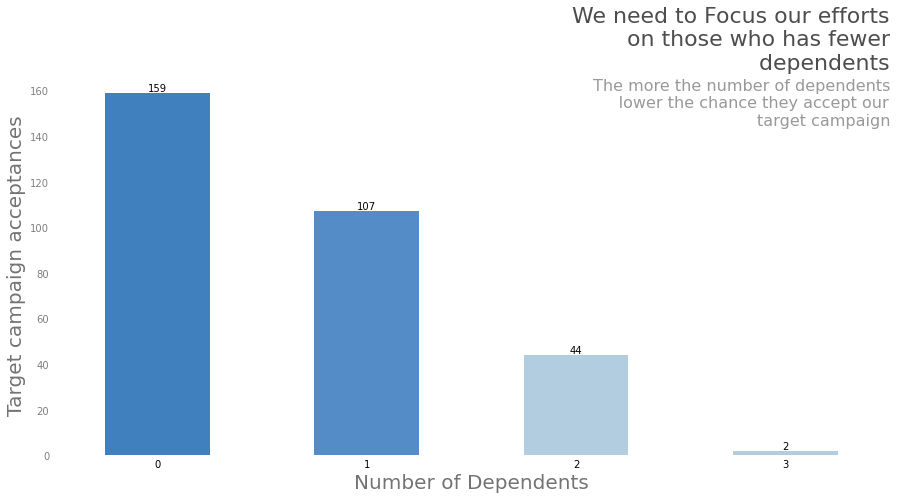

In [178]:
plt.figure(figsize=(15,7))
plt.box(False)
colors = ['#4080bf', '#538cc6', '#b3cde0', '#b3cde0', '#b3cde0']
aux.plot(kind='bar', color=colors)
plt.title("We need to Focus our efforts\non those who has fewer\n dependents",
          size=22, loc='right', color=title_grey)
text="The more the number of dependents\n\tlower the chance they accept our\n\t\t\t\t\t\t  target campaign".replace("\t","     ")
plt.text(2.08, 145, text, color=grey, size=16)
plt.xlabel("Number of Dependents",size=20, color=light_grey)
plt.ylabel("Target campaign acceptances", size=20, color=light_grey)
plt.xticks(rotation=0)
plt.yticks(color='grey')
plt.tick_params(axis='both', which='both', length=0)

for i in range(len(y)):
    plt.annotate(str(y[i]), xy=(x[i],y[i]), ha='center', va='bottom')
plt.show()

## 5.3 Multivariate Analysis

In [179]:
numerical_attributes = ifood.select_dtypes( include=['int64', 'float64'] )
categorical_attributes = ifood.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 5.3.1. Numerical Attributes

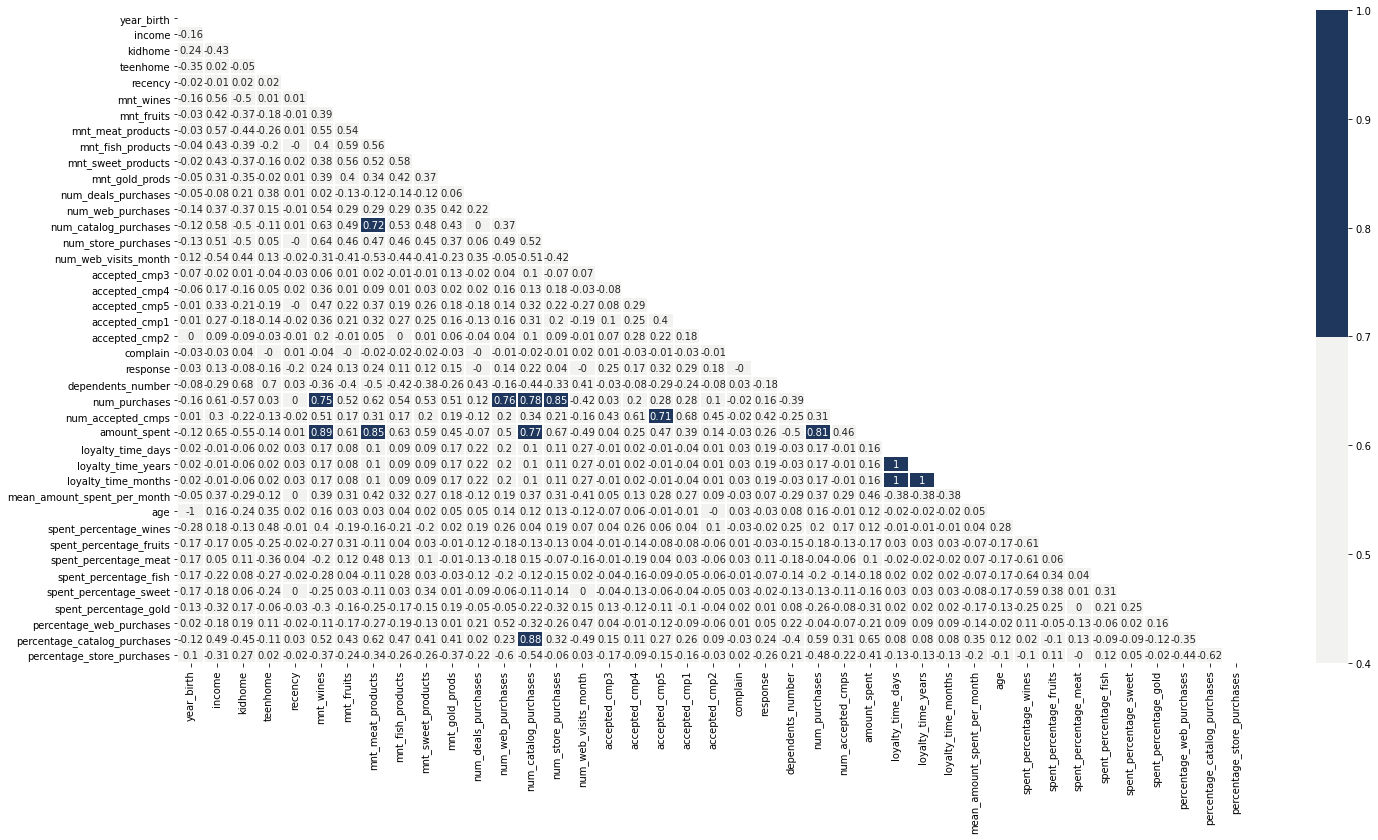

In [180]:
plt.figure(figsize=(24, 12))
correlations = numerical_attributes.corr().round(2)
mask = np.triu(np.ones_like(correlations, dtype=np.bool))
sns.heatmap(correlations, mask=mask, linewidths=1, annot=True, cmap=['#F2F2F0','#1F375D'], vmin=0.40) #vmax=-0.40
plt.show()

### 5.3.2. Categorical Attributes

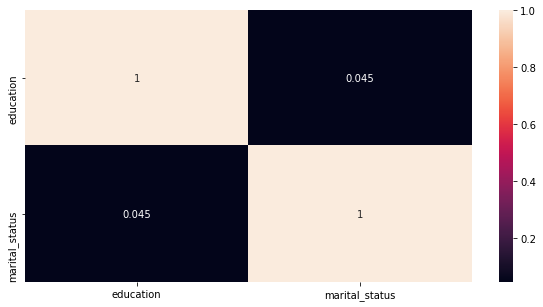

In [186]:
categorical_corr = get_categorical_corr(categorical_attributes)
plt.figure(figsize=(10, 5))
sns.heatmap( categorical_corr, annot=True )
plt.show()


**ps: o que faria diferente?**

- Pensei em criar hipóteses não tão objetivas porque a ambiguidade facilita "se perder" e ver diferentes possíveis histórias nos dados, mas a essa falta de direção é como a ausência de uma métrica. Então como avaliar sem ter uma uma métrica? Ou das possíveis maneiras de se medir, qual utilizar? Por isso, **uma melhoria seria a definição de hipóteses diretas e objetivas, sabendo exatamente o que deve ser medido e pensando como o resultado pode afetar a tomada de decisão pelo time de negócio. Uma abordagem mais [4Ps](https://medium.com/ifood-tech/o-recheio-%C3%A9-contexto-e-relev%C3%A2ncia-488e58b30e2d) nas hipóteses.**


- Remover outliers antes de determinadas análises (cheguei a fazer em certos momentos, mas poderia expandir). Talvez realizar um análise a parte para os outliers. O que viríamos a descobrir? Alternativas que podem ser aplicadas no próximo ciclo CRISP-DM.


- Utilizar a média entre a média e mediana como métrica monetária? Pesquisar sobre.       